*Analize Risk, Hedging, Cost, Benefits and Oportunity on QQQ and IWM using 10Y of data*

### imports

In [1]:
pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tools.eval_measures import aic
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from arch import arch_model
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
pd.options.plotting.backend = "matplotlib"

/home/flor/anaconda3/envs/env2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-04 11:21:22.645103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Exploratory data analysis

## Download data

In [3]:
start = '2014-11-19'
end = '2024-11-19'
data = yf.download(['QQQ', 'IWM', '^GSPC'], start=start, end=end) # require data from yf, add S&P to have a 
                                                                  # reference with the market
RF = yf.download(['^IRX'], start=start, end=end) # risk-free rate reference
data.head()

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


Price        Adj Close                               Close              \
Ticker             IWM        QQQ        ^GSPC         IWM         QQQ   
Date                                                                     
2014-11-19  100.742188  95.313873  2048.719971  115.150002  103.209999   
2014-11-20  101.870781  95.738716  2052.750000  116.440002  103.669998   
2014-11-21  101.993294  95.923393  2063.500000  116.580002  103.870003   
2014-11-24  103.209328  96.671425  2069.409912  117.970001  104.680000   
2014-11-25  103.288071  96.819183  2067.030029  118.059998  104.839996   

Price                          High                                  Low  \
Ticker            ^GSPC         IWM         QQQ        ^GSPC         IWM   
Date                                                                       
2014-11-19  2048.719971  116.250000  103.570000  2052.139893  114.370003   
2014-11-20  2052.750000  116.459999  103.760002  2053.840088  114.620003   
2014-11-21  2063.500000  118.120003  104.690002  2071.459961  116.160004   
2014-11-24  2069.409912  118.050003  104.730003  2070.169922  116.580002   
2014-11-25  2067.030029  118.779999  105.150002  2074.209961  117.529999   

Price                                      Open                           \
Ticker             QQQ        ^GSPC         IWM         QQQ        ^GSPC   
Date                                                                       
2014-11-19  102.730003  2040.369995  116.250000  103.570000  2051.159912   
2014-11-20  102.690002  2040.489990  114.620003  102.769997  2045.869995   
2014-11-21  103.540001  2056.750000  118.080002  104.589996  2057.459961   
2014-11-24  104.059998  2065.070068  116.739998  104.150002  2065.070068   
2014-11-25  104.570000  2064.750000  118.220001  104.839996  2070.149902   

Price         Volume                        
Ticker           IWM       QQQ       ^GSPC  
Date                                        
2014-11-19  38258700  23760200  3390850000  
2014-11-20  26555000  22874000  3128290000  
2014-11-21  43240400  34049100  3916420000  
2014-11-24  24573200  17928300  3128060000  
2014-11-25  26745900  17526000  3392940000

## basic statistics

In [4]:
data.describe()

Price     Adj Close                                  Close               \
Ticker          IWM          QQQ        ^GSPC          IWM          QQQ   
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean     153.976119   233.519438  3310.661673   163.114010   239.317611   
std       38.052014   115.701751  1054.304054    35.338812   114.266859   
min       84.452553    90.186386  1829.079956    94.790001    96.320000   
25%      123.403622   131.161705  2397.805054   135.952503   137.982498   
50%      146.592361   188.844063  2978.025024   157.385002   195.184998   
75%      185.234058   325.396660  4175.270142   190.675003   332.327499   
max      241.699997   514.140015  6001.350098   242.559998   514.140015   

Price                       High                                    Low  \
Ticker        ^GSPC          IWM          QQQ        ^GSPC          IWM   
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean    3310.661673   164.408025   241.013645  3327.811027   161.741864   
std     1054.304054    35.696672   115.105093  1059.562649    35.014318   
min     1829.079956    95.400002    97.050003  1847.000000    93.639999   
25%     2397.805054   136.919998   138.630005  2403.242615   134.982506   
50%     2978.025024   158.239998   195.645004  2990.265015   156.364998   
75%     4175.270142   191.877499   334.360001  4195.467407   188.330002   
max     6001.350098   244.460007   515.580017  6017.310059   241.929993   

Price                                    Open                            \
Ticker          QQQ        ^GSPC          IWM          QQQ        ^GSPC   
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean     237.376260  3291.229423   163.157874   239.272345  3310.180292   
std      113.336731  1048.490356    35.393576   114.279927  1054.052255   
min       84.739998  1810.099976    94.080002    94.230003  1833.400024   
25%      137.447502  2385.572571   136.197506   138.124996  2394.817566   
50%      193.040001  2963.255005   157.510002   194.395004  2979.320068   
75%      329.212502  4149.300171   190.180004   332.190010  4174.602661   
max      512.409973  5986.689941   243.740005   515.369995  6008.859863   

Price         Volume                              
Ticker           IWM           QQQ         ^GSPC  
count   2.516000e+03  2.516000e+03  2.516000e+03  
mean    2.869014e+07  4.142203e+07  4.001241e+09  
std     1.218854e+07  2.201153e+07  9.540420e+08  
min     1.200000e+03  7.079300e+06  1.296530e+09  
25%     2.034338e+07  2.546135e+07  3.422252e+09  
50%     2.588680e+07  3.628500e+07  3.815925e+09  
75%     3.415128e+07  5.184270e+07  4.337118e+09  
max     9.561280e+07  1.986858e+08  9.976520e+09

In [5]:
RF.describe()

Price     Adj Close        Close         High          Low         Open  \
Ticker         ^IRX         ^IRX         ^IRX         ^IRX         ^IRX   
count   2515.000000  2515.000000  2515.000000  2515.000000  2515.000000   
mean       1.707559     1.707559     1.718330     1.696748     1.709029   
std        1.854795     1.854795     1.857183     1.847633     1.854641   
min       -0.105000    -0.105000    -0.100000    -0.235000    -0.108000   
25%        0.100000     0.100000     0.103000     0.096500     0.100000   
50%        1.023000     1.023000     1.033000     1.018000     1.028000   
75%        2.371500     2.371500     2.378000     2.365000     2.373000   
max        5.348000     5.348000     5.348000     5.348000     5.348000   

Price   Volume  
Ticker    ^IRX  
count   2515.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0

'Adj Close' column will be used

## check for missing values

In [6]:
# are there missing values?
data.isna().sum()

Price      Ticker
Adj Close  IWM       0
           QQQ       0
           ^GSPC     0
Close      IWM       0
           QQQ       0
           ^GSPC     0
High       IWM       0
           QQQ       0
           ^GSPC     0
Low        IWM       0
           QQQ       0
           ^GSPC     0
Open       IWM       0
           QQQ       0
           ^GSPC     0
Volume     IWM       0
           QQQ       0
           ^GSPC     0
dtype: int64

There are no missing values

## plot stock prices

<Axes: xlabel='Date'>

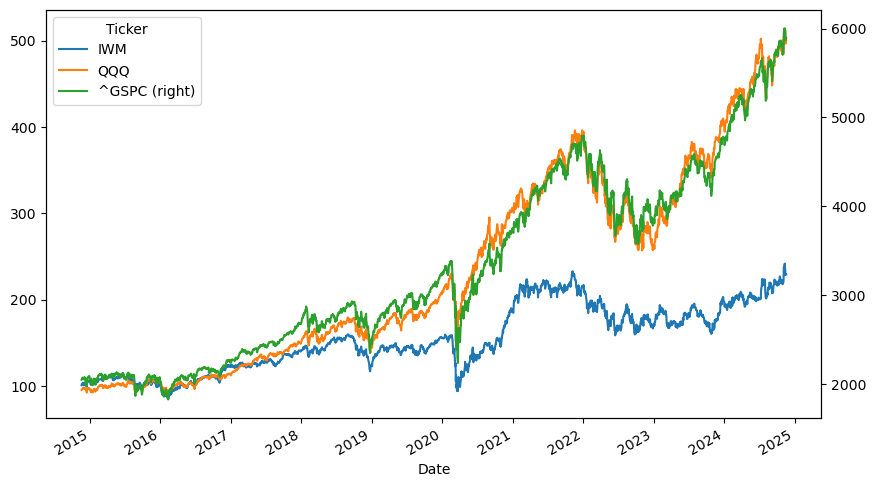

In [7]:
data['Adj Close'].plot(secondary_y='^GSPC', figsize=(10, 6))

There is a period of high volatility and a great drop during COVID on 2020. The correlation btw these stock prices seems to be high.

## plot monthly stock prices

To smooth data, plot monthly stock prices

<Axes: xlabel='Date'>

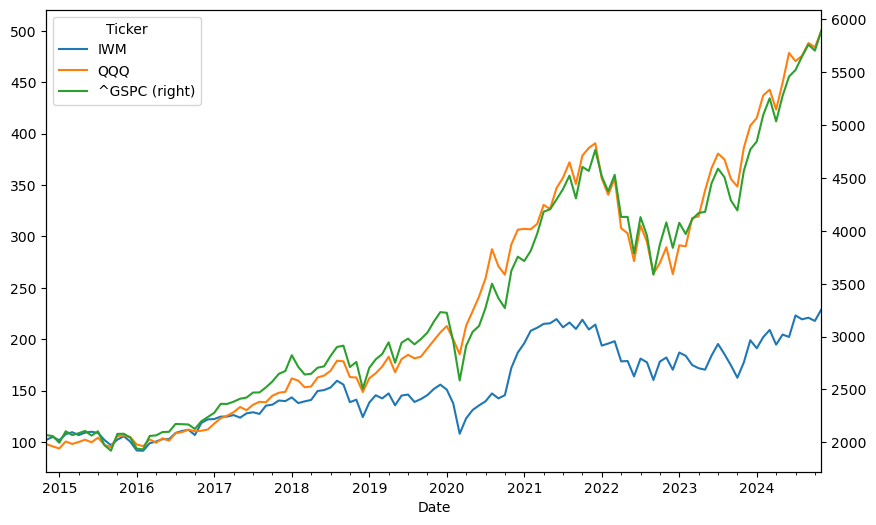

In [8]:
data1m = data.resample('1ME', label='right').last()
data1m['Adj Close'].plot(secondary_y='^GSPC', figsize=(10, 6))

## Compute log-returns

In [9]:
# compute returns
rets = np.log(data / data.shift(1))
rets.head().round(3)

Price      Adj Close                Close                 High                \
Ticker           IWM    QQQ  ^GSPC    IWM    QQQ  ^GSPC    IWM    QQQ  ^GSPC   
Date                                                                           
2014-11-19       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-11-20     0.011  0.004  0.002  0.011  0.004  0.002  0.002  0.002  0.001   
2014-11-21     0.001  0.002  0.005  0.001  0.002  0.005  0.014  0.009  0.009   
2014-11-24     0.012  0.008  0.003  0.012  0.008  0.003 -0.001  0.000 -0.001   
2014-11-25     0.001  0.002 -0.001  0.001  0.002 -0.001  0.006  0.004  0.002   

Price         Low                 Open               Volume                
Ticker        IWM    QQQ  ^GSPC    IWM    QQQ  ^GSPC    IWM    QQQ  ^GSPC  
Date                                                                       
2014-11-19    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2014-11-20  0.002 -0.000  0.000 -0.014 -0.008 -0.003 -0.365 -0.038 -0.081  
2014-11-21  0.013  0.008  0.008  0.030  0.018  0.006  0.488  0.398  0.225  
2014-11-24  0.004  0.005  0.004 -0.011 -0.004  0.004 -0.565 -0.641 -0.225  
2014-11-25  0.008  0.005 -0.000  0.013  0.007  0.002  0.085 -0.023  0.081

plot cumulative log-returns

In [10]:
pd.options.plotting.backend = "plotly"
rets['Adj Close'].cumsum().plot()

## plot cumulative monthly returns

<Axes: xlabel='Date'>

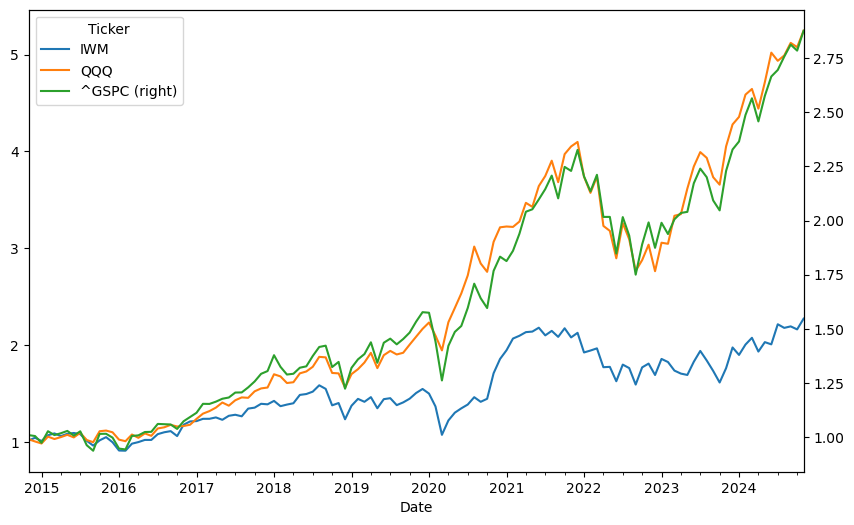

In [11]:
# plot cumulative monthly returns 
pd.options.plotting.backend = "matplotlib"
rets['Adj Close'].cumsum().apply(np.exp).resample('1ME', label='right').last().plot(figsize=(10, 6), secondary_y='^GSPC')

<Axes: xlabel='Date'>

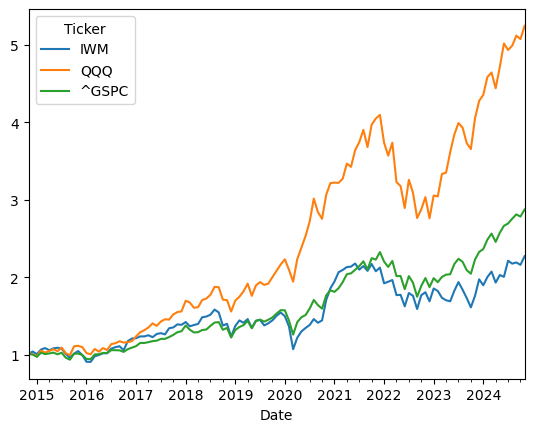

In [12]:
rets['Adj Close'].cumsum().apply(np.exp).resample('1ME', label='right').last().plot()

## plot returns

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

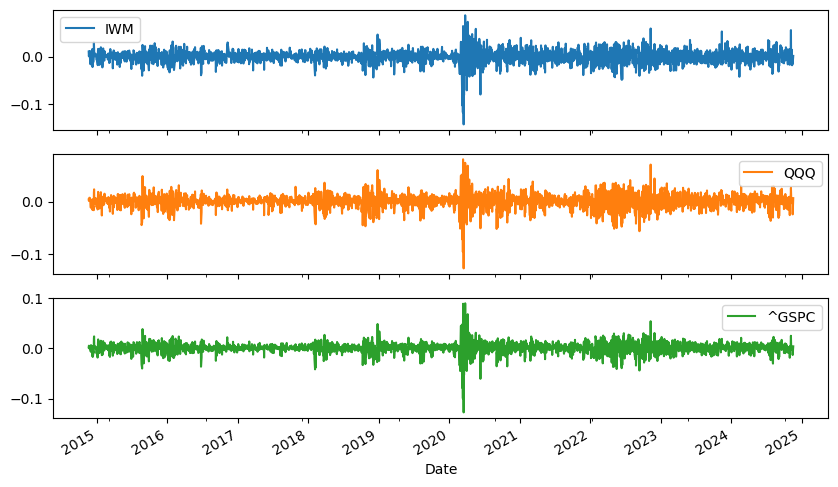

In [13]:
rets.dropna(inplace=True)
rets['Adj Close'].plot(subplots=True, figsize=(10, 6))

## plot scatter matrix

array([[<Axes: xlabel='IWM', ylabel='IWM'>,
        <Axes: xlabel='QQQ', ylabel='IWM'>,
        <Axes: xlabel='^GSPC', ylabel='IWM'>],
       [<Axes: xlabel='IWM', ylabel='QQQ'>,
        <Axes: xlabel='QQQ', ylabel='QQQ'>,
        <Axes: xlabel='^GSPC', ylabel='QQQ'>],
       [<Axes: xlabel='IWM', ylabel='^GSPC'>,
        <Axes: xlabel='QQQ', ylabel='^GSPC'>,
        <Axes: xlabel='^GSPC', ylabel='^GSPC'>]], dtype=object)

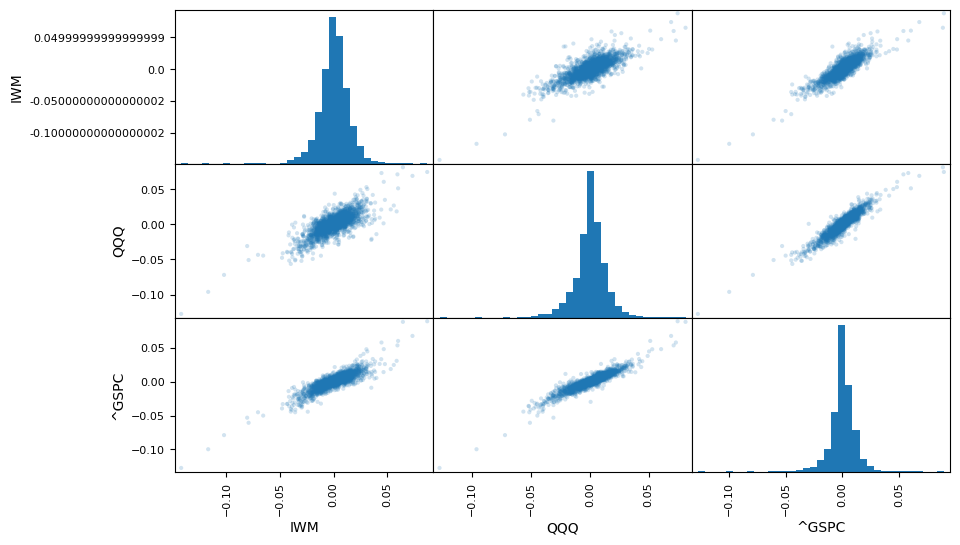

In [14]:
pd.plotting.scatter_matrix(rets['Adj Close'],
                            alpha=0.2,
                            diagonal='hist',
                            hist_kwds={'bins': 35},
                            figsize=(10, 6))

## plot return's linear regressions

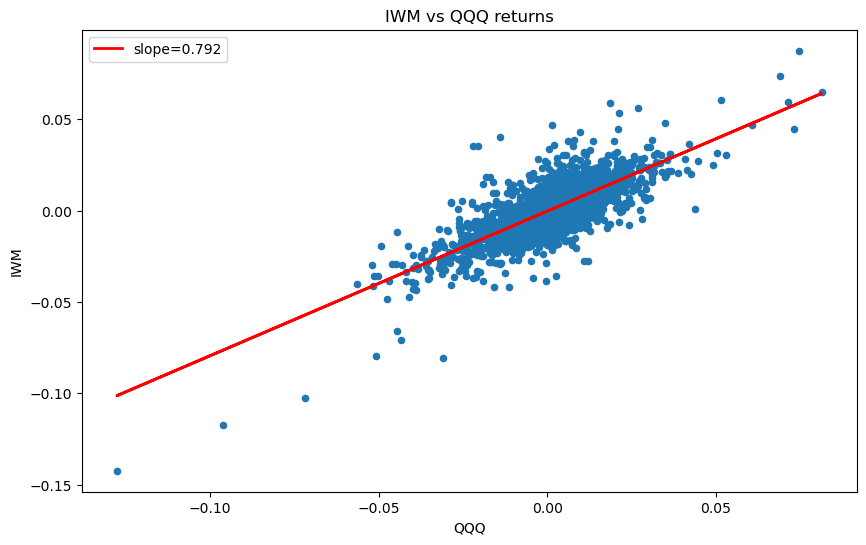

In [15]:
reg = np.polyfit(rets['Adj Close']['QQQ'], rets['Adj Close']['IWM'], deg=1)
ax = rets['Adj Close'].plot(kind='scatter', x='QQQ', y='IWM', figsize=(10, 6))
ax.plot(rets['Adj Close']['QQQ'], np.polyval(reg, rets['Adj Close']['QQQ']), 'r', label=f'slope={round(reg[0],3)}',lw=2)
ax.set_ylabel('IWM')
ax.set_xlabel('QQQ')
ax.set_title('IWM vs QQQ returns')
ax.legend()

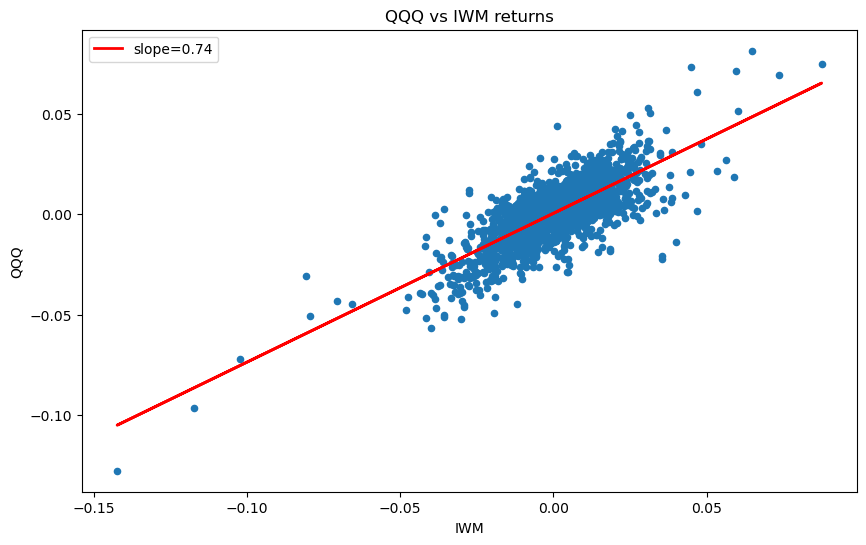

In [16]:
reg = np.polyfit(rets['Adj Close']['IWM'], rets['Adj Close']['QQQ'], deg=1)
ax = rets['Adj Close'].plot(kind='scatter', x='IWM', y='QQQ', figsize=(10, 6))
ax.plot(rets['Adj Close']['IWM'], np.polyval(reg, rets['Adj Close']['IWM']), 'r', label=f'slope={round(reg[0],3)}',lw=2)
ax.set_ylabel('QQQ')
ax.set_xlabel('IWM')
ax.set_title('QQQ vs IWM returns')
ax.legend()

## compute correlations

In [17]:
rets['Adj Close'].corr()

Ticker       IWM       QQQ     ^GSPC
Ticker                              
IWM     1.000000  0.765551  0.867674
QQQ     0.765551  1.000000  0.929151
^GSPC   0.867674  0.929151  1.000000

Correlations are high, but usually correlations do not remain constant in time. Let's see how it varies with a 20d RW.

## plot correlations with 20 days rolling window

Text(0.5, 1.0, '20 days RW correlation btw QQQ and IWM')

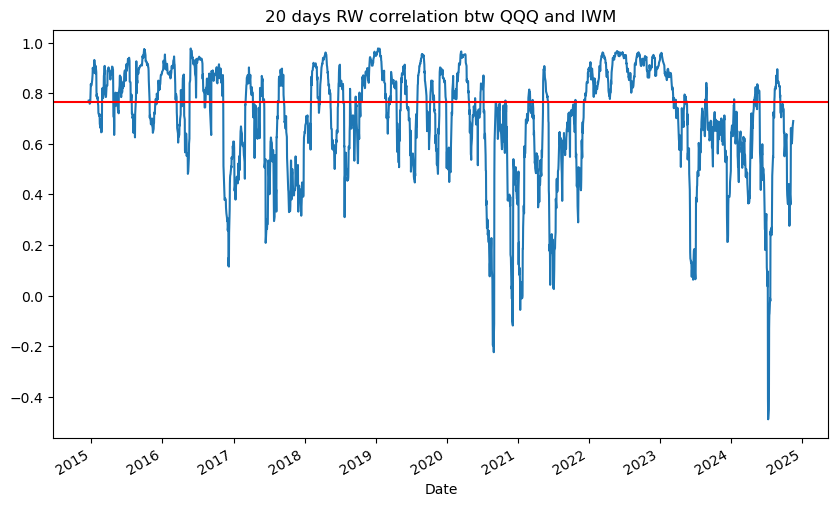

In [18]:
rets = np.log(data / data.shift(1))
rets.dropna(inplace=True)
ax = rets['Adj Close']['QQQ'].rolling(window=20).corr(rets['Adj Close']['IWM']).plot(figsize=(10, 6))
ax.axhline(rets.corr().iloc[0, 1], c='r')
ax.set_title('20 days RW correlation btw QQQ and IWM')

There are periods where this 20d RW shows that IWM and QQQ were no correlated, and also it can be seen a negative correlation recently.

## explore autocorrelation

### QQQ returns

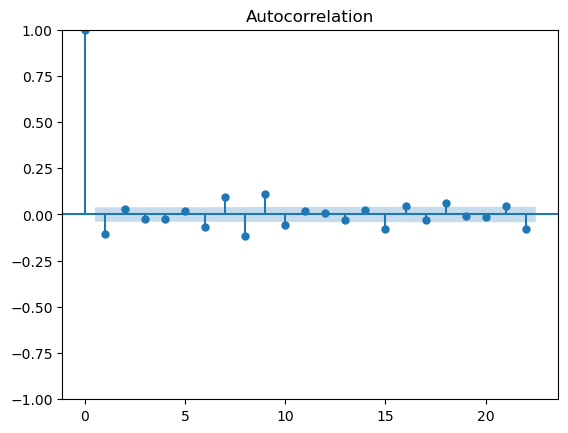

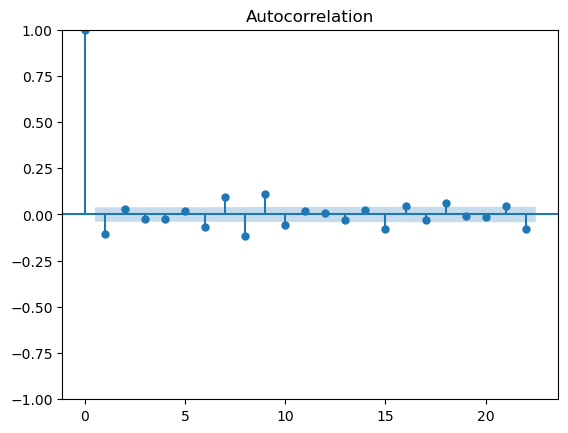

In [19]:
plot_acf(rets['Adj Close'].QQQ, lags=22)

There are significant paks at lags 1, 6, 7, 8, 9, 15 and 22, so that the QQQ returns series is autocorrelated

### IWM returns

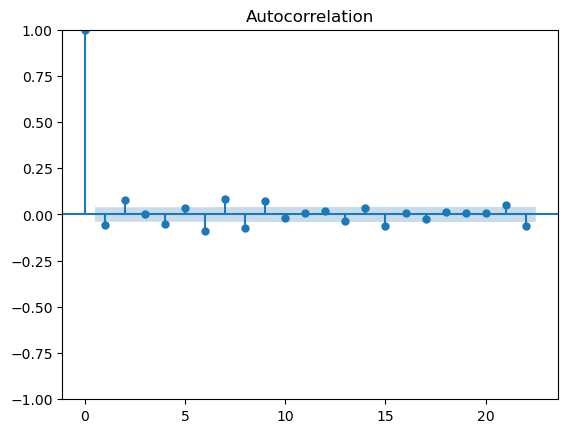

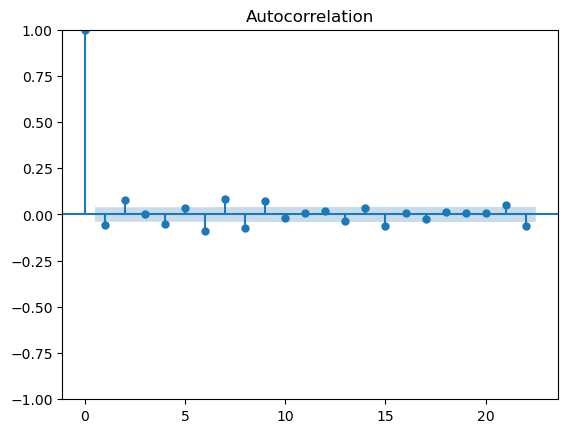

In [20]:
plot_acf(rets['Adj Close'].IWM, lags=22)

There are significant paks at lags 2, 6, 7, and 8, so that the IWM returns series is also autocorrelated

## explore seasonality

### QQQ returns

In [21]:
r = rets.copy().asfreq('B',method='pad') # data preprocessing

#### yearly

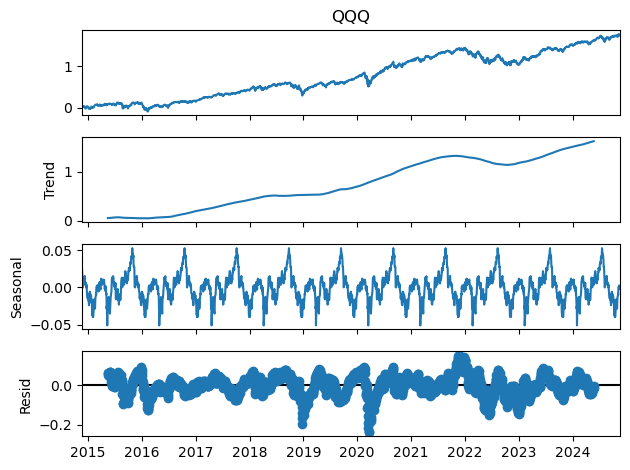

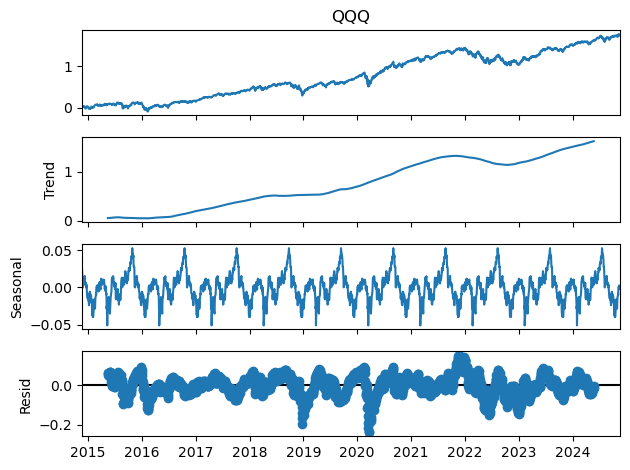

In [22]:
result = seasonal_decompose(r['Adj Close'].QQQ.cumsum(), period=253)
result.plot()

monthly

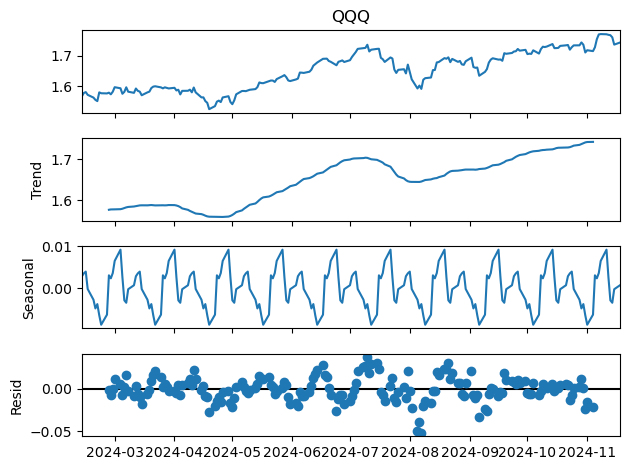

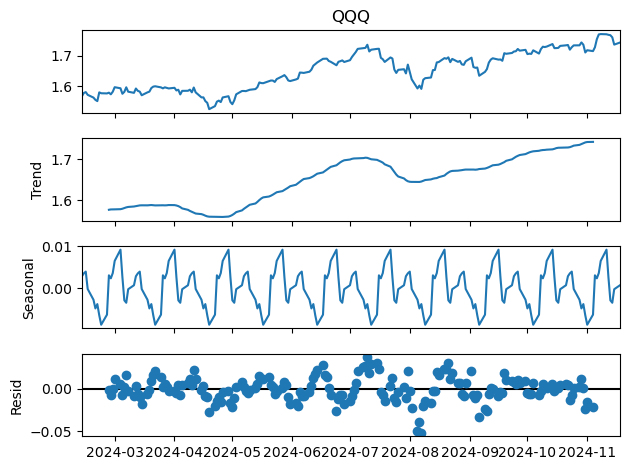

In [23]:
result = seasonal_decompose(r['Adj Close'].QQQ.cumsum()[-200:], period=20)
result.plot()

#### weekly

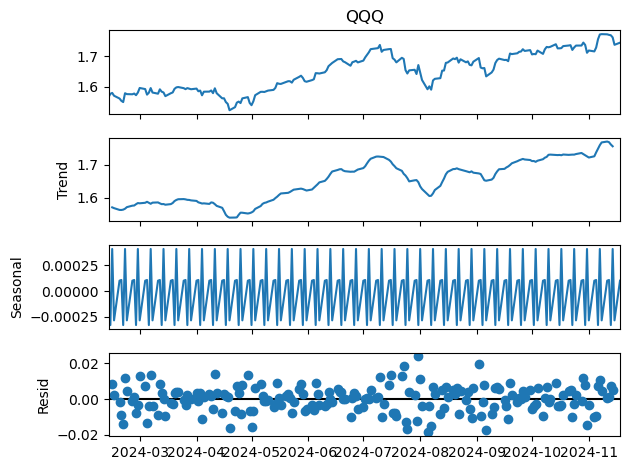

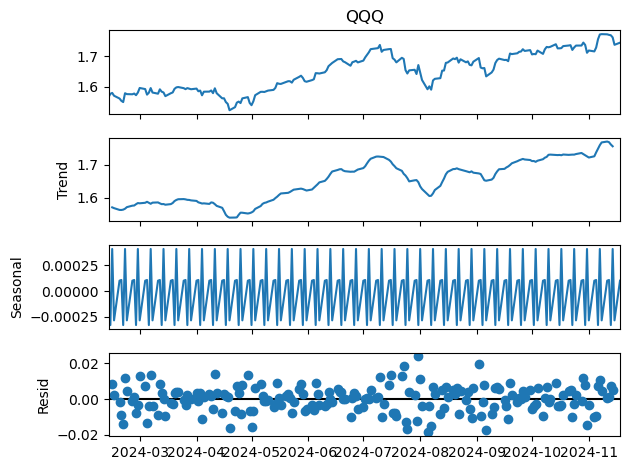

In [24]:
result = seasonal_decompose(r['Adj Close'].QQQ.cumsum()[-200:], period=5)
result.plot()

It can be observed that the cumulative returns time series has weekly, monthly and yearly seasonalities.

## explore volatility

### 20D RW daily volatility for returns

In [25]:
pd.options.plotting.backend='plotly'
rets.rolling(window=20).std()['Adj Close'].plot(title='daily volatility')

## explore forecasting

### prophet

#### data preprocessing

In [26]:
period = 5 # amount of forecasting Bdays
df = pd.DataFrame() # create a DF with Prophet's requirements
df['ds'] = data['Adj Close'].QQQ.index[:-period] # column of dates named 'ds'
df['y'] = data['Adj Close'].QQQ.values[:-period] # column of values named 'y'
df.index = df.ds # set index as dates
df.tail()

ds           y
ds                               
2024-11-05 2024-11-05  492.209991
2024-11-06 2024-11-06  505.579987
2024-11-07 2024-11-07  513.539978
2024-11-08 2024-11-08  514.140015
2024-11-11 2024-11-11  513.840027

### fit

In [27]:
atdim = 21 # average amount of trading days in a month
m = Prophet(changepoint_prior_scale = 0.05,
            weekly_seasonality = True,
            daily_seasonality = False,
            yearly_seasonality = True,
            changepoints = None)
m.add_seasonality(name='monthly',period=atdim,fourier_order=5)
m.fit(df)

11:21:37 - cmdstanpy - INFO - Chain [1] start processing
11:21:39 - cmdstanpy - INFO - Chain [1] done processing


### make predictions

In [28]:
future = m.make_future_dataframe(periods=period,freq='B') # make df with future dates
future.tail()

ds
2511 2024-11-12
2512 2024-11-13
2513 2024-11-14
2514 2024-11-15
2515 2024-11-18

In [29]:
forecast = m.predict(future) # make predictions on future dates
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2511 2024-11-12  504.129510  491.896576  516.159929
2512 2024-11-13  504.964441  492.577577  516.932384
2513 2024-11-14  505.605521  492.738518  518.418961
2514 2024-11-15  505.676751  492.979243  518.388530
2515 2024-11-18  506.908798  494.174875  519.042651

### plot forecast

/home/flor/anaconda3/envs/env2/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/flor/anaconda3/envs/env2/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



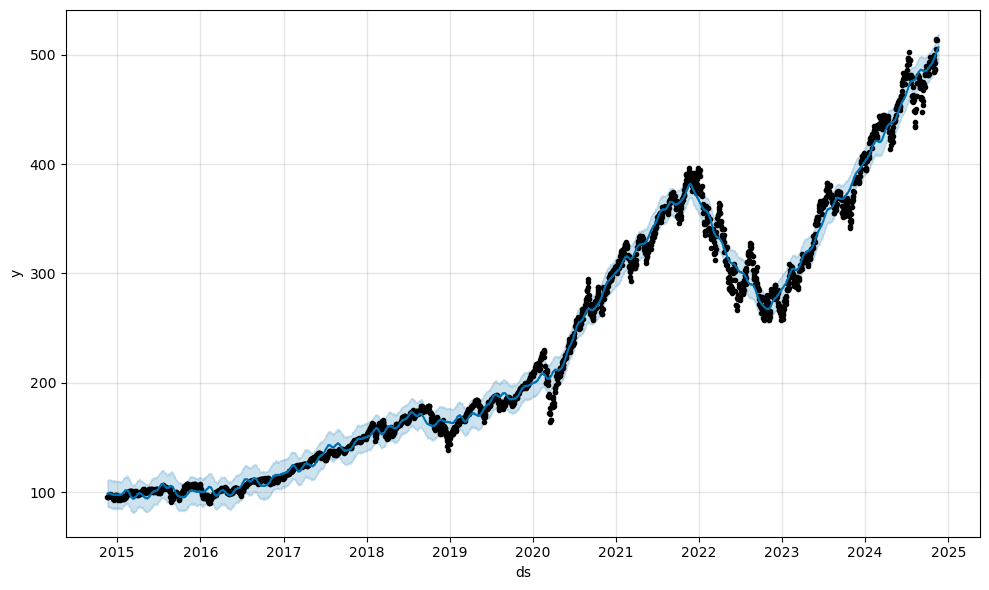

In [30]:
fig1 = m.plot(forecast)

### backtesting: merge fit & forecast with actual data

In [31]:
df2 = pd.merge(data['Adj Close'].QQQ, forecast, how='inner', right_on='ds', left_index=True)
df2.head()

QQQ         ds      trend  yhat_lower  yhat_upper  trend_lower  \
0  95.313873 2014-11-19  97.163208   87.134178  110.568382    97.163208   
1  95.738716 2014-11-20  97.170972   86.501701  111.003564    97.170972   
2  95.923393 2014-11-21  97.178736   86.277528  111.028199    97.178736   
3  96.671425 2014-11-24  97.202029   85.924839  111.792191    97.202029   
4  96.819183 2014-11-25  97.209793   86.167980  111.514018    97.209793   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    97.163208        1.147919              1.147919              1.147919   
1    97.170972        1.387642              1.387642              1.387642   
2    97.178736        1.530768              1.530768              1.530768   
3    97.202029        2.024443              2.024443              2.024443   
4    97.209793        1.927818              1.927818              1.927818   

   ...    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0  ...  0.044544      0.044544      0.044544  0.754879      0.754879   
1  ...  0.321074      0.321074      0.321074  0.849269      0.849269   
2  ...  0.753603      0.753603      0.753603  0.920778      0.920778   
3  ...  0.817346      0.817346      0.817346  1.004456      1.004456   
4  ...  0.303898      0.303898      0.303898  0.992364      0.992364   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0      0.754879                   0.0                         0.0   
1      0.849269                   0.0                         0.0   
2      0.920778                   0.0                         0.0   
3      1.004456                   0.0                         0.0   
4      0.992364                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  98.311127  
1                         0.0  98.558614  
2                         0.0  98.709505  
3                         0.0  99.226471  
4                         0.0  99.137611  

[5 rows x 23 columns]

### plot forecast vs actual

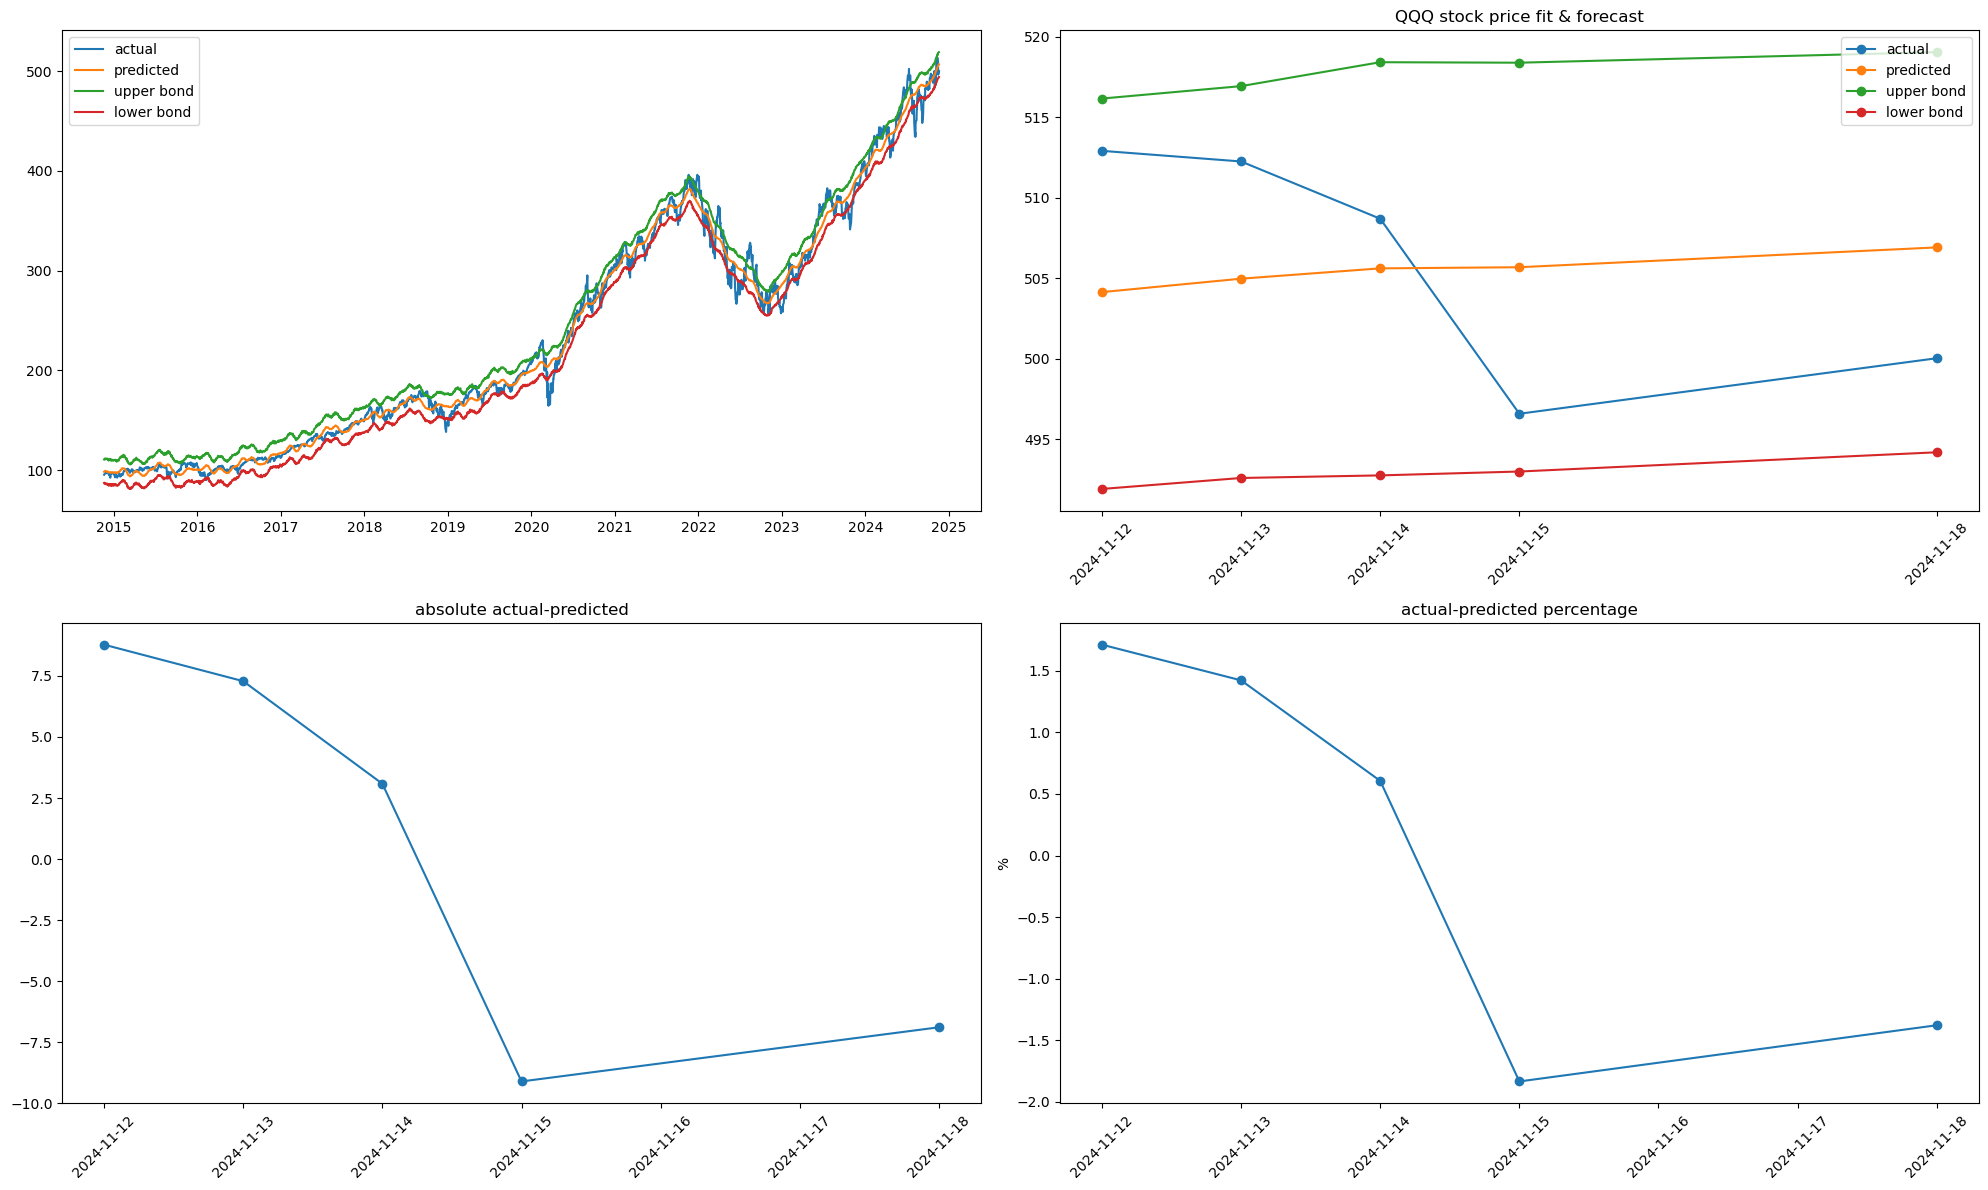

In [32]:
fig, axs = plt.subplots(2,2, figsize = (20,12))

axs[0,1].plot(df2.ds[-period:], df2.QQQ[-period:], marker='o', label='actual')
axs[0,1].plot(df2.ds[-period:], df2.yhat[-period:],  marker='o',label='predicted')
axs[0,1].plot(df2.ds[-period:], df2.yhat_upper[-period:], marker='o', label='upper bond')
axs[0,1].plot(df2.ds[-period:], df2.yhat_lower[-period:], marker='o', label='lower bond')
axs[0,1].set_xticks(df2.ds[-period:])
axs[0,1].set_title('QQQ stock price forecast')
axs[0,1].tick_params('x',labelrotation=45)
axs[0,1].legend()

axs[0,0].plot(df2.ds, df2.QQQ, label='actual')
axs[0,0].plot(df2.ds, df2.yhat, label='predicted')
axs[0,0].plot(df2.ds, df2.yhat_upper, label='upper bond')
axs[0,0].plot(df2.ds, df2.yhat_lower, label='lower bond')
axs[0,1].set_title('QQQ stock price fit & forecast')
axs[0,0].legend()

labels=df2.ds[-5:]
axs[1,0].plot(df2.ds[-period:], df2.QQQ[-period:]-df2.yhat[-period:],marker='o', label='actual-predicted')
axs[1,0].set_title('absolute actual-predicted')
axs[1,0].tick_params('x',labelrotation=45)

axs[1,1].plot(df2.ds[-period:], (df2.QQQ[-period:]-df2.yhat[-period:])/df2.QQQ[-period:] *100,marker='o', label='actual-predicted %')
axs[1,1].set_title('actual-predicted percentage')
axs[1,1].tick_params('x',labelrotation=45)
axs[1,1].set_ylabel('%')
fig.tight_layout()

5-days predictions for the QQQ stock price on the (2024-11-12, 2024-11-18) period using 10Y data has a maximum error of ~$10 (~2%) in stock price prediction.

# explore trading strategies

# strategy1

1. For each day, *i* , the previous *k* days of the stock prices are used as a window for fitting.
2. The fitting model is used to make a prediction for the next day returns.
3. If the prediction is negative the stock is shorted at the previous close, while if it is positive it is longed.

In [33]:
# Implement the strategy during 3M on QQQ
tick='QQQ'
k = 60 # use k days of data for fitting
n = 60 # hold the strategy for n days
period = 1 # amount of forecasting Bdays
ds, bs , ys = [], [], [] # store forecast dates, long (+1) or short (-1) positions, predicted return 
for i in range(len(rets)-n, len(rets)): # loop for the last M
    # create a DF with Prophet's requirements       
    df = pd.DataFrame() 
    df['ds'] = data['Adj Close'][tick].index.values[i-k:i-period] # column of dates named 'ds'
    df['y'] = data['Adj Close'][tick].values[i-k:i-period] # column of values named 'y'
    df.index = df.ds # set index as dates
    # model fit
    m = Prophet(changepoint_prior_scale = 0.05,
                weekly_seasonality = True,
                daily_seasonality = False,
                yearly_seasonality = True,
                changepoints = None)
    m.add_seasonality(name='monthly',period=atdim,fourier_order=5)
    m.fit(df)
    # make predictions
    future = m.make_future_dataframe(periods=period,freq='B') # make df with future dates
    forecast = m.predict(future) # make predictions on future dates
    # store predictions
    ds.append(df.ds.iloc[-1]) # store date of the long/short position based on future prediction
    ys.append(np.log(forecast.yhat.iloc[-1]/df.y.iloc[-1])) # store future return
    if ys[-1]<0: # store decision
        bs.append(-1) # short
    else:
        bs.append(1) # long


11:21:40 - cmdstanpy - INFO - Chain [1] start processing
11:21:41 - cmdstanpy - INFO - Chain [1] done processing
11:21:41 - cmdstanpy - INFO - Chain [1] start processing
11:21:41 - cmdstanpy - INFO - Chain [1] done processing
11:21:41 - cmdstanpy - INFO - Chain [1] start processing
11:21:41 - cmdstanpy - INFO - Chain [1] done processing
11:21:41 - cmdstanpy - INFO - Chain [1] start processing
11:21:41 - cmdstanpy - INFO - Chain [1] done processing
11:21:42 - cmdstanpy - INFO - Chain [1] start processing
11:21:42 - cmdstanpy - INFO - Chain [1] done processing
11:21:42 - cmdstanpy - INFO - Chain [1] start processing
11:21:42 - cmdstanpy - INFO - Chain [1] done processing
11:21:42 - cmdstanpy - INFO - Chain [1] start processing
11:21:42 - cmdstanpy - INFO - Chain [1] done processing
11:21:42 - cmdstanpy - INFO - Chain [1] start processing
11:21:43 - cmdstanpy - INFO - Chain [1] done processing
11:21:43 - cmdstanpy - INFO - Chain [1] start processing
11:21:43 - cmdstanpy - INFO - Chain [1]

In [34]:
# create forecast dataframe
df = pd.DataFrame({'dates':ds,
                   'bs': bs,
                   'y_pred': ys})
# merge with actual data for backtesting
df2 = pd.merge(rets['Adj Close'][tick], df, how='inner', right_on='dates', left_index=True)
df2.head()

QQQ      dates  bs    y_pred
0  0.004653 2024-08-21  -1 -0.030303
1 -0.015982 2024-08-22  -1 -0.030738
2  0.010787 2024-08-23   1  0.040647
3 -0.009756 2024-08-26   1  0.017479
4  0.002983 2024-08-27   1  0.022768

this stratgy outperforms Buy&Hold for QQQ during 8-21-2024 
and 11-13-2024 by 12.0%


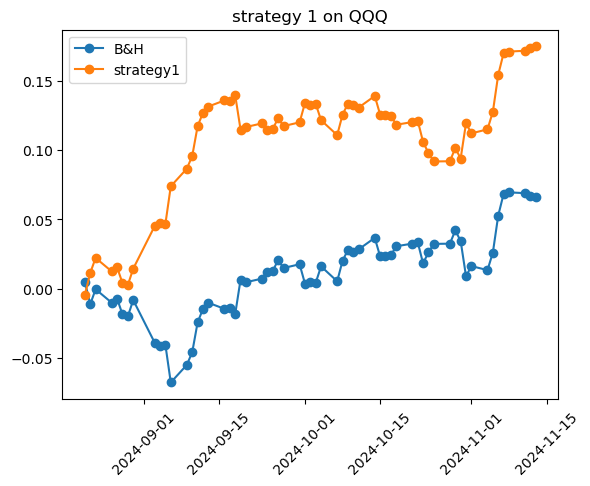

In [35]:
# plot results
plt.plot(df2.dates,df2[tick].cumsum(),marker='o',label='B&H')
plt.plot(df2.dates,(df2[tick]*df2.bs).cumsum(),marker='o',label='strategy1')
plt.title(f'strategy 1 on {tick}')
plt.xticks(rotation=45)
plt.legend()

outp = np.exp((df2[tick]*df2.bs).cumsum().iloc[-1])-np.exp(df2[tick].cumsum().iloc[-1])
print(f'this stratgy outperforms Buy&Hold for {tick} during {df2.dates.iloc[0].month}-{df2.dates.iloc[0].day}-{df2.dates.iloc[0].year} \nand {df2.dates.iloc[-1].month}-{df2.dates.iloc[-1].day}-{df2.dates.iloc[-1].year} by {np.round(outp,2)*100}%')

consider transaction costs

In [36]:
iv = 1000 # initial investment
# with buy&hold strategy, an investor would end up with $(bah[-1])
bah = np.ones(len(df2))*iv*np.exp(df2.QQQ[0])
for i in range(1,len(df2)):
    bah[i] = bah[i-1]*np.exp(df2.QQQ[i])
print(f'with buy&hold strategy, an investor starting with ${iv} would end up with ${np.round(bah[-1])}')

tc = 2.5
s1 = np.ones(len(df2))*iv*np.exp(df2.QQQ[0]*bs[0])
for i in range(1,len(df2)):
    s1[i] = s1[i-1]*np.exp(df2.QQQ[i]*bs[i])-2.5 # consider $2.5 transaction cost/trade
print(f'with s1 strategy, an investor starting with ${iv} would end up with ${np.round(s1[-1])}')

with buy&hold strategy, an investor starting with $1000 would end up with $1068.0
with s1 strategy, an investor starting with $1000 would end up with $1033.0


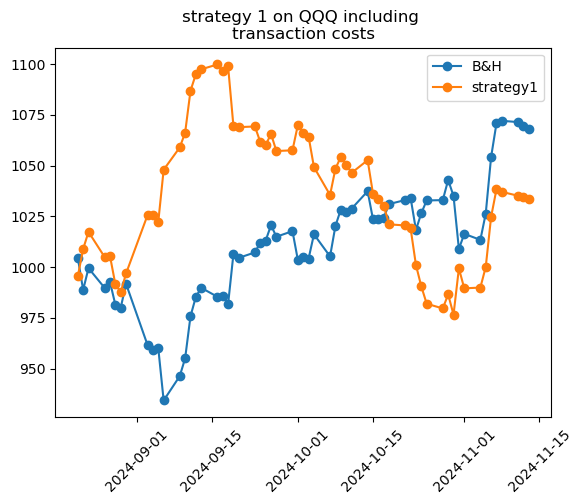

In [37]:
# plot results w trans costs: $2.5/trade
plt.plot(df2.dates,bah,marker='o',label='B&H')
plt.plot(df2.dates,s1,marker='o',label='strategy1')
plt.title(f'strategy 1 on {tick} including \ntransaction costs')
plt.xticks(rotation=45)
plt.legend()

### compute equity risk premium

In [38]:
# period to compute it
start = df.dates.iloc[0] 
end = df.dates.iloc[-1]
diy = 360
# percentage returns
retsp = data/data.shift()
# average of risk-free rate over that period
rf = RF.Close[start:end].mean().values[0] * (end-start).days/diy
# average of market return over that period
rm = (retsp['Adj Close']['^GSPC'][start:end].mean()-1)*100
# beta of ticker
cov = retsp['Adj Close'][['^GSPC',tick]][start:end].cov().iloc[0,1]
var = retsp['Adj Close']['^GSPC'][start:end].var()
beta = cov/var
print(f'start: {start}\nend: {end}\nrf: {np.round(rf,2)}\nrm: {np.round(rm,2)}\nbeta: {np.round(beta,2)}')
ra = rf + beta * (rm - rf)
print(f'ra: {np.round(ra,2)}')

start: 2024-08-21 00:00:00
end: 2024-11-13 00:00:00
rf: 1.08
rm: 0.11
beta: 1.34
ra: -0.21


# strategy2

1. For each day, *i* , the previous *k* days of the stock prices are used as a window for fitting.
2. The fitting model is used to make a prediction for the next day returns.
3. If the prediction is negative do nothing, while if it is positive it is longed.

In [39]:
# create long-only column
df2['s2'] = [df2.bs[i] if bs[i]==1 else 0 for i in range(len(df2))]

this stratgy outperforms Buy&Hold for QQQ during 8-21-2024 
and 11-13-2024 by 6.0%


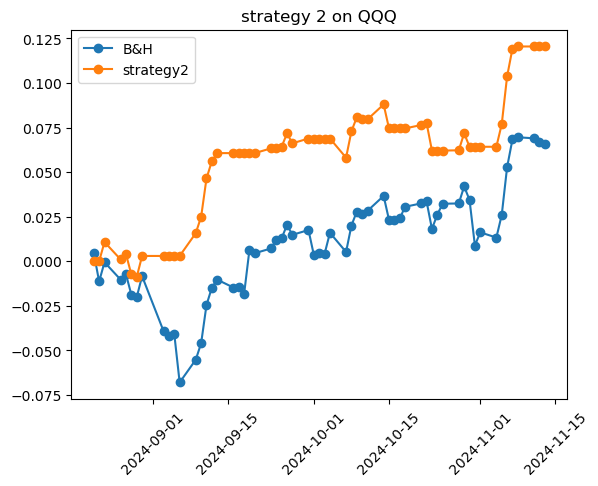

In [40]:
# plot results
plt.plot(df2.dates,df2[tick].cumsum(),marker='o',label='B&H')
plt.plot(df2.dates,(df2[tick]*df2.s2).cumsum(),marker='o',label='strategy2')
plt.title(f'strategy 2 on {tick}')
plt.xticks(rotation=45)
plt.legend()

outp = np.exp((df2[tick]*df2.s2).cumsum().iloc[-1])-np.exp(df2[tick].cumsum().iloc[-1])
print(f'this stratgy outperforms Buy&Hold for {tick} during {df2.dates.iloc[0].month}-{df2.dates.iloc[0].day}-{df2.dates.iloc[0].year} \nand {df2.dates.iloc[-1].month}-{df2.dates.iloc[-1].day}-{df2.dates.iloc[-1].year} by {np.round(outp,2)*100}%')

consider transaction costs

In [41]:
iv = 1000 # initial investment
# with buy&hold strategy, an investor would end up with $(bah[-1])
bah = np.ones(len(df2))*iv*np.exp(df2[tick][0])
for i in range(1,len(df2)):
    bah[i] = bah[i-1]*np.exp(df2[tick][i])
print(f'with buy&hold strategy, an investor starting with ${iv} would end up with ${np.round(bah[-1])}')

tc = 2.5
s2 = np.ones(len(df2))*iv*np.exp(df2[tick][0]*bs[0])
for i in range(1,len(df2)):
    if df2.s2[i]==1:
        s2[i] = s2[i-1]*np.exp(df2[tick][i]*bs[i])-2.5 # consider $2.5 transaction cost/trade
    else:
        s2[i] = s2[i-1]*np.exp(df2[tick][i])
print(f'with s2 strategy, an investor starting with ${iv} would end up with ${np.round(s2[-1])}')

with buy&hold strategy, an investor starting with $1000 would end up with $1068.0
with s2 strategy, an investor starting with $1000 would end up with $974.0


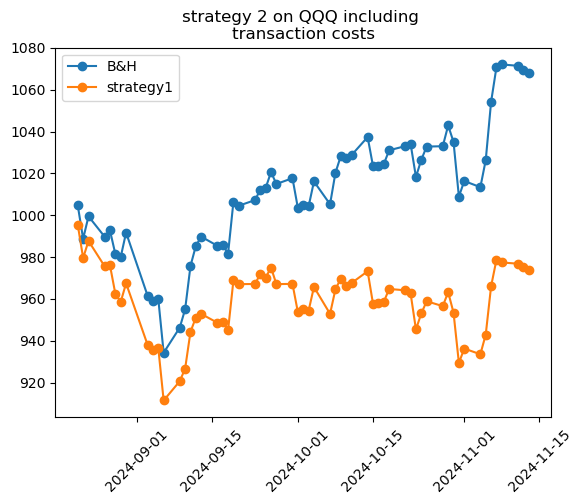

In [42]:
# plot results w trans costs: $2.5/trade
plt.plot(df2.dates,bah,marker='o',label='B&H')
plt.plot(df2.dates,s2,marker='o',label='strategy1')
plt.title(f'strategy 2 on {tick} including \ntransaction costs')
plt.xticks(rotation=45)
plt.legend()

### compute equity risk premium

In [43]:
# period to compute it
start = df.dates.iloc[0] 
end = df.dates.iloc[-1]
diy = 360
# percentage returns
retsp = data/data.shift()
# average of risk-free rate over that period
rf = RF.Close[start:end].mean().values[0] * (end-start).days/diy
# average of market return over that period
rm = (retsp['Adj Close']['^GSPC'][start:end].mean()-1)*100
# beta of ticker
cov = retsp['Adj Close'][['^GSPC',tick]][start:end].cov().iloc[0,1]
var = retsp['Adj Close']['^GSPC'][start:end].var()
beta = cov/var
print(f'start: {start}\nend: {end}\nrf: {np.round(rf,2)}\nrm: {np.round(rm,2)}\nbeta: {np.round(beta,2)}')
ra = rf + beta * (rm - rf)
print(f'ra: {np.round(ra,2)}')

start: 2024-08-21 00:00:00
end: 2024-11-13 00:00:00
rf: 1.08
rm: 0.11
beta: 1.34
ra: -0.21


# conclusion

When considering transaction costs, using a long/short or long-only strategy with prophet forecasting over the last three months can be inconvenient. This largely depends on transaction costs; in this instance, a constant cost of $2.50 is used. Additionally, the effectiveness of the strategy is influenced by the initial investment, as the cumulative returns of these strategies exceed those of a buy-and-hold (B&H) strategy. 

For further analysis, we should backtest the strategy over different periods and consider maintaining the strategies for longer durations. As shown below, if the strategies are held for one year, or if the initial investment were larger, the strategy would have proven to be more effective. Another aspect worth exploring is the use of different forecasting methods, such as those tested in the Appendix.

In [44]:
n = 252 # hold the strategy for n days
period = 1 # amount of forecasting Bdays
ds, bs , ys = [], [], [] # store forecast dates, long (+1) or short (-1) positions, predicted return 
for i in range(len(rets)-n, len(rets)): # loop for the last M
    # create a DF with Prophet's requirements       
    df = pd.DataFrame() 
    df['ds'] = data['Adj Close'][tick].index.values[i-k:i-period] # column of dates named 'ds'
    df['y'] = data['Adj Close'][tick].values[i-k:i-period] # column of values named 'y'
    df.index = df.ds # set index as dates
    # model fit
    m = Prophet(changepoint_prior_scale = 0.05,
                weekly_seasonality = True,
                daily_seasonality = False,
                yearly_seasonality = True,
                changepoints = None)
    m.add_seasonality(name='monthly',period=atdim,fourier_order=5)
    m.fit(df)
    # make predictions
    future = m.make_future_dataframe(periods=period,freq='B') # make df with future dates
    forecast = m.predict(future) # make predictions on future dates
    # store predictions
    ds.append(df.ds.iloc[-1]) # store date of the long/short position based on future prediction
    ys.append(np.log(forecast.yhat.iloc[-1]/df.y.iloc[-1])) # store future return
    if ys[-1]<0: # store decision
        bs.append(-1) # short
    else:
        bs.append(1) # long


11:22:01 - cmdstanpy - INFO - Chain [1] start processing
11:22:01 - cmdstanpy - INFO - Chain [1] done processing
11:22:01 - cmdstanpy - INFO - Chain [1] start processing
11:22:02 - cmdstanpy - INFO - Chain [1] done processing
11:22:02 - cmdstanpy - INFO - Chain [1] start processing
11:22:02 - cmdstanpy - INFO - Chain [1] done processing
11:22:02 - cmdstanpy - INFO - Chain [1] start processing
11:22:03 - cmdstanpy - INFO - Chain [1] done processing
11:22:03 - cmdstanpy - INFO - Chain [1] start processing
11:22:03 - cmdstanpy - INFO - Chain [1] done processing
11:22:03 - cmdstanpy - INFO - Chain [1] start processing
11:22:04 - cmdstanpy - INFO - Chain [1] done processing
11:22:04 - cmdstanpy - INFO - Chain [1] start processing
11:22:04 - cmdstanpy - INFO - Chain [1] done processing
11:22:04 - cmdstanpy - INFO - Chain [1] start processing
11:22:04 - cmdstanpy - INFO - Chain [1] done processing
11:22:04 - cmdstanpy - INFO - Chain [1] start processing
11:22:05 - cmdstanpy - INFO - Chain [1]

In [45]:
# create forecast dataframe
df = pd.DataFrame({'dates':ds,
                   'bs': bs,
                   'y_pred': ys})
# merge with actual data for backtesting
df2 = pd.merge(rets['Adj Close'][tick], df, how='inner', right_on='dates', left_index=True)
df2.head()

QQQ      dates  bs    y_pred
0  0.021298 2023-11-14   1  0.024103
1  0.000752 2023-11-15   1  0.029672
2  0.000855 2023-11-16   1  0.029967
3  0.000233 2023-11-17   1  0.028140
4  0.012102 2023-11-20  -1 -0.007425

this stratgy outperforms Buy&Hold for QQQ during 11-14-2023 
and 11-13-2024 by 110.05%


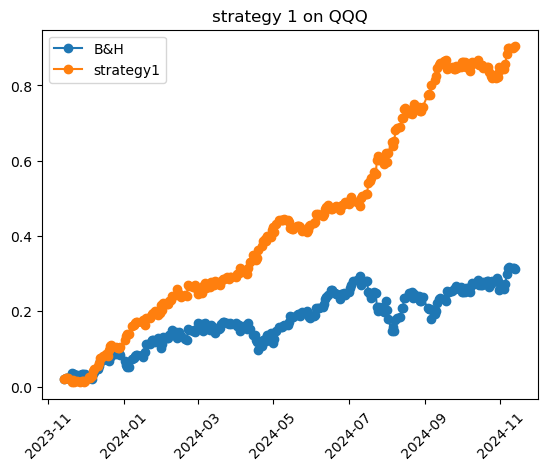

In [46]:
# plot results
plt.plot(df2.dates,df2[tick].cumsum(),marker='o',label='B&H')
plt.plot(df2.dates,(df2[tick]*df2.bs).cumsum(),marker='o',label='strategy1')
plt.title(f'strategy 1 on {tick}')
plt.xticks(rotation=45)
plt.legend()

outp = np.exp((df2[tick]*df2.bs).cumsum().iloc[-1])-np.exp(df2[tick].cumsum().iloc[-1])
print(f'this stratgy outperforms Buy&Hold for {tick} during {df2.dates.iloc[0].month}-{df2.dates.iloc[0].day}-{df2.dates.iloc[0].year} \nand {df2.dates.iloc[-1].month}-{df2.dates.iloc[-1].day}-{df2.dates.iloc[-1].year} by {np.round(outp*100,2)}%')

consider transaction costs

In [47]:
iv = 1000 # initial investment
# with buy&hold strategy, an investor would end up with $(bah[-1])
bah = np.ones(len(df2))*iv*np.exp(df2.QQQ[0])
for i in range(1,len(df2)):
    bah[i] = bah[i-1]*np.exp(df2.QQQ[i])
print(f'with buy&hold strategy, an investor starting with ${iv} would end up with ${np.round(bah[-1])}')

tc = 2.5
s1 = np.ones(len(df2))*iv*np.exp(df2.QQQ[0]*bs[0])
for i in range(1,len(df2)):
    s1[i] = s1[i-1]*np.exp(df2.QQQ[i]*bs[i])-2.5 # consider $2.5 transaction cost/trade
print(f'with s1 strategy, an investor starting with ${iv} would end up with ${np.round(s1[-1])}')

with buy&hold strategy, an investor starting with $1000 would end up with $1367.0
with s1 strategy, an investor starting with $1000 would end up with $1444.0


In [48]:
iv = 100 # initial investment
# with buy&hold strategy, an investor would end up with $(bah[-1])
bah = np.ones(len(df2))*iv*np.exp(df2.QQQ[0])
for i in range(1,len(df2)):
    bah[i] = bah[i-1]*np.exp(df2.QQQ[i])
print(f'with buy&hold strategy, an investor starting with ${iv} would end up with ${np.round(bah[-1])}')

tc = 2.5
s1 = np.ones(len(df2))*iv*np.exp(df2.QQQ[0]*bs[0])
for i in range(1,len(df2)):
    s1[i] = s1[i-1]*np.exp(df2.QQQ[i]*bs[i])-2.5 # consider $2.5 transaction cost/trade
print(f'with s1 strategy, an investor starting with ${iv} would end up with ${np.round(s1[-1])}')

with buy&hold strategy, an investor starting with $100 would end up with $137.0
with s1 strategy, an investor starting with $100 would end up with $-777.0


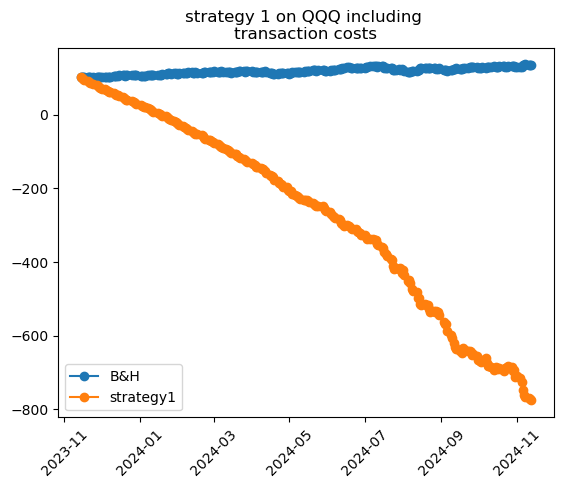

In [49]:
# plot results w trans costs: $2.5/trade
plt.plot(df2.dates,bah,marker='o',label='B&H')
plt.plot(df2.dates,s1,marker='o',label='strategy1')
plt.title(f'strategy 1 on {tick} including \ntransaction costs')
plt.xticks(rotation=45)
plt.legend()

### compute equity risk premium

In [50]:
# period to compute it
start = df.dates.iloc[0] 
end = df.dates.iloc[-1]
diy = 360
# percentage returns
retsp = data/data.shift()
# average of risk-free rate over that period
rf = RF.Close[start:end].mean().values[0] * (end-start).days/diy
# average of market return over that period
rm = (retsp['Adj Close']['^GSPC'][start:end].mean()-1)*100
# beta of ticker
cov = retsp['Adj Close'][['^GSPC',tick]][start:end].cov().iloc[0,1]
var = retsp['Adj Close']['^GSPC'][start:end].var()
beta = cov/var
print(f'start: {start}\nend: {end}\nrf: {np.round(rf,2)}\nrm: {np.round(rm,2)}\nbeta: {np.round(beta,2)}')
ra = rf + beta * (rm - rf)
print(f'ra: {np.round(ra,2)}')

start: 2023-11-14 00:00:00
end: 2024-11-13 00:00:00
rf: 5.14
rm: 0.12
beta: 1.33
ra: -1.55


# strategy2

1. For each day, *i* , the previous *k* days of the stock prices are used as a window for fitting.
2. The fitting model is used to make a prediction for the next day returns.
3. If the prediction is negative do nothing, while if it is positive it is longed.

In [51]:
# create long-only column
df2['s2'] = [df2.bs[i] if bs[i]==1 else 0 for i in range(len(df2))]

this stratgy outperforms Buy&Hold for QQQ during 11-14-2023 
and 11-13-2024 by 47.0%


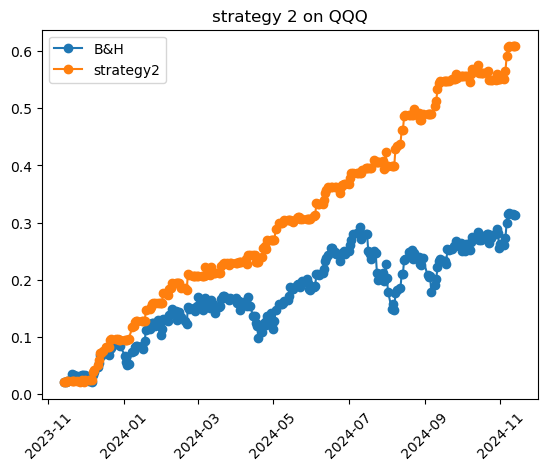

In [52]:
# plot results
plt.plot(df2.dates,df2[tick].cumsum(),marker='o',label='B&H')
plt.plot(df2.dates,(df2[tick]*df2.s2).cumsum(),marker='o',label='strategy2')
plt.title(f'strategy 2 on {tick}')
plt.xticks(rotation=45)
plt.legend()

outp = np.exp((df2[tick]*df2.s2).cumsum().iloc[-1])-np.exp(df2[tick].cumsum().iloc[-1])
print(f'this stratgy outperforms Buy&Hold for {tick} during {df2.dates.iloc[0].month}-{df2.dates.iloc[0].day}-{df2.dates.iloc[0].year} \nand {df2.dates.iloc[-1].month}-{df2.dates.iloc[-1].day}-{df2.dates.iloc[-1].year} by {np.round(outp,2)*100}%')

consider transaction costs

In [53]:
iv = 1000 # initial investment
# with buy&hold strategy, an investor would end up with $(bah[-1])
bah = np.ones(len(df2))*iv*np.exp(df2[tick][0])
for i in range(1,len(df2)):
    bah[i] = bah[i-1]*np.exp(df2[tick][i])
print(f'with buy&hold strategy, an investor starting with ${iv} would end up with ${np.round(bah[-1])}')

tc = 2.5
s2 = np.ones(len(df2))*iv*np.exp(df2[tick][0]*bs[0])
for i in range(1,len(df2)):
    if df2.s2[i]==1:
        s2[i] = s2[i-1]*np.exp(df2[tick][i]*bs[i])-2.5 # consider $2.5 transaction cost/trade
    else:
        s2[i] = s2[i-1]*np.exp(df2[tick][i])
print(f'with s2 strategy, an investor starting with ${iv} would end up with ${np.round(s2[-1])}')

with buy&hold strategy, an investor starting with $1000 would end up with $1367.0
with s2 strategy, an investor starting with $1000 would end up with $983.0


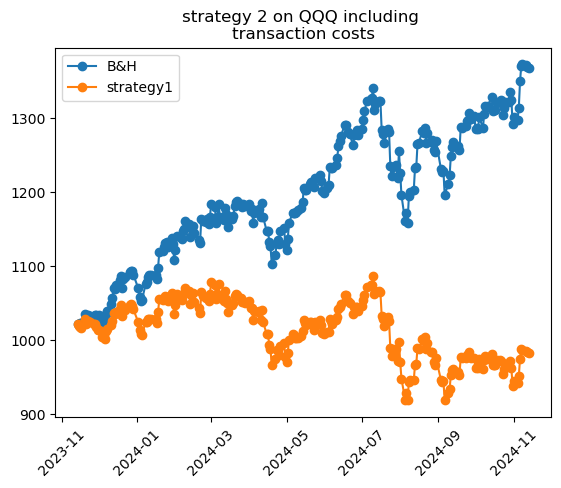

In [54]:
# plot results w trans costs: $2.5/trade
plt.plot(df2.dates,bah,marker='o',label='B&H')
plt.plot(df2.dates,s2,marker='o',label='strategy1')
plt.title(f'strategy 2 on {tick} including \ntransaction costs')
plt.xticks(rotation=45)
plt.legend()

# trading strategy on IWM

In [55]:
# Implement the strategy during 3M on IWM
tick='IWM'
k=60 # use 3M of data for fitting
period = 1 # amount of forecasting Bdays
n = 60 # hold the strategy for n days
ds, bs , ys = [], [], [] # store forecast dates, long (+1) or short (-1) positions, predicted return 
for i in range(len(rets)-n, len(rets)): # loop for the last 3M
    # create a DF with Prophet's requirements       
    df = pd.DataFrame() 
    df['ds'] = data['Adj Close'][tick].index.values[i-k:i-period] # column of dates named 'ds'
    df['y'] = data['Adj Close'][tick].values[i-k:i-period] # column of values named 'y'
    df.index = df.ds # set index as dates
    # model fit
    m = Prophet(changepoint_prior_scale = 0.05,
                weekly_seasonality = True,
                daily_seasonality = False,
                yearly_seasonality = True,
                changepoints = None)
    m.add_seasonality(name='monthly',period=atdim,fourier_order=5)
    m.fit(df)
    # make predictions
    future = m.make_future_dataframe(periods=period,freq='B') # make df with future dates
    forecast = m.predict(future) # make predictions on future dates
    # store predictions
    ds.append(df.ds.iloc[-1]) # store date of the long/short position based on future prediction
    ys.append(np.log(forecast.yhat.iloc[-1]/df.y.iloc[-1])) # store future return
    if ys[-1]<0: # store decision
        bs.append(-1) # short
    else:
        bs.append(1) # long


11:23:42 - cmdstanpy - INFO - Chain [1] start processing
11:23:43 - cmdstanpy - INFO - Chain [1] done processing
11:23:43 - cmdstanpy - INFO - Chain [1] start processing
11:23:43 - cmdstanpy - INFO - Chain [1] done processing
11:23:43 - cmdstanpy - INFO - Chain [1] start processing
11:23:43 - cmdstanpy - INFO - Chain [1] done processing
11:23:43 - cmdstanpy - INFO - Chain [1] start processing
11:23:43 - cmdstanpy - INFO - Chain [1] done processing
11:23:44 - cmdstanpy - INFO - Chain [1] start processing
11:23:44 - cmdstanpy - INFO - Chain [1] done processing
11:23:44 - cmdstanpy - INFO - Chain [1] start processing
11:23:44 - cmdstanpy - INFO - Chain [1] done processing
11:23:44 - cmdstanpy - INFO - Chain [1] start processing
11:23:45 - cmdstanpy - INFO - Chain [1] done processing
11:23:45 - cmdstanpy - INFO - Chain [1] start processing
11:23:45 - cmdstanpy - INFO - Chain [1] done processing
11:23:45 - cmdstanpy - INFO - Chain [1] start processing
11:23:45 - cmdstanpy - INFO - Chain [1]

In [56]:
# create forecast dataframe
df = pd.DataFrame({'dates':ds,
                   'bs': bs,
                   'y_pred': ys})
# merge with actual data for backtesting
df2 = pd.merge(rets['Adj Close'][tick], df, how='inner', right_on='dates', left_index=True)
df2.head()

IWM      dates  bs    y_pred
0  0.012940 2024-08-21  -1 -0.029507
1 -0.008857 2024-08-22  -1 -0.025726
2  0.031436 2024-08-23   1  0.103531
3  0.000318 2024-08-26   1  0.043257
4 -0.007787 2024-08-27   1  0.031525

this stratgy outperforms the Buy&Hols Strategy for IWM during 8-21-2024 
and 11-13-2024 by 12.0%


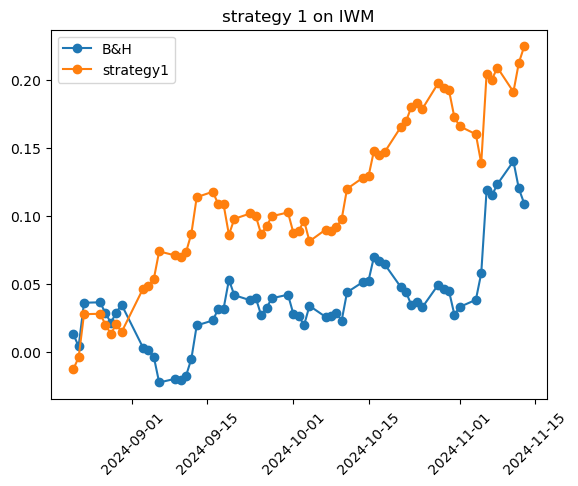

In [57]:
# plot results
plt.plot(df2.dates,df2[tick].cumsum().apply('exp')-1,marker='o',label='B&H')
plt.plot(df2.dates,(df2[tick]*df2.bs).cumsum().apply('exp')-1,marker='o',label='strategy1')
plt.xticks(rotation=45)
plt.title(f'strategy 1 on {tick}')
plt.legend()

outp = (df2[tick]*df2.bs).cumsum().apply('exp').iloc[-1]-df2[tick].cumsum().apply('exp').iloc[-1]
print(f'this stratgy outperforms the Buy&Hols Strategy for {tick} during {df2.dates.iloc[0].month}-{df2.dates.iloc[0].day}-{df2.dates.iloc[0].year} \nand {df2.dates.iloc[-1].month}-{df2.dates.iloc[-1].day}-{df2.dates.iloc[-1].year} by {np.round(outp,2)*100}%')

In [58]:
tick

'IWM'

### compute equity risk premium

In [59]:
# period to compute it
start = df.dates.iloc[0] 
end = df.dates.iloc[-1]
diy = 360
# percentage returns
retsp = data/data.shift()
# average of risk-free rate over that period
rf = RF.Close[start:end].mean().values[0] * (end-start).days/diy
# average of market return over that period
rm = (retsp['Adj Close']['^GSPC'][start:end].mean()-1)*100
# beta of ticker
cov = retsp['Adj Close'][['^GSPC',tick]][start:end].cov().iloc[0,1]
var = retsp['Adj Close']['^GSPC'][start:end].var()
beta = cov/var
print(f'start: {start}\nend: {end}\nrf: {np.round(rf,2)}\nrm: {np.round(rm,2)}\nbeta: {np.round(beta,2)}')
ra = rf + beta * (rm - rf)
print(f'ra: {np.round(ra,2)}')

start: 2024-08-21 00:00:00
end: 2024-11-13 00:00:00
rf: 1.08
rm: 0.11
beta: 1.35
ra: -0.22


Since the correlation btw IWM and QQQ tickers is high, we expect to have similar results on the tests performed on IWM.

# Hedging

How could an investor hedge for losses with these 2 assets?

In [60]:
print(f'the largest loss on an intraday trading on QQQ over the past 10Y was {round(min(retsp['Adj Close'].QQQ.dropna()-1)*100,2)}')
print(f'the largest loss on an intraday trading on IWM over the past 10Y was {round(min(retsp['Adj Close'].IWM.dropna()-1)*100,2)}')
print(f'the largest monthly-loss on QQQ over the past 10Y was {round(min(retsp['Adj Close'].QQQ.dropna().cumprod().resample('1ME').last()-1)*100,2)}')
print(f'the largest monthly-loss on IWM over the past 10Y was {round(min(retsp['Adj Close'].IWM.dropna().cumprod().resample('1ME').last()-1)*100,2)}')

the largest loss on an intraday trading on QQQ over the past 10Y was -11.98
the largest loss on an intraday trading on IWM over the past 10Y was -13.27
the largest monthly-loss on QQQ over the past 10Y was -1.68
the largest monthly-loss on IWM over the past 10Y was -9.15


Focus the analysis over the last month

In [61]:
start = '2024-10-18'
end = '2024-11-18'
print(f'the largest loss on an intraday trading on QQQ over the past month was {round(min(retsp.loc[start:end]['Adj Close'].QQQ.dropna()-1)*100,2)}')
print(f'the largest loss on an intraday trading on IWM over the past month was {round(min(retsp.loc[start:end]['Adj Close'].IWM.dropna()-1)*100,2)}')
print(f'the largest monthly-loss on QQQ over the past month was {round(min(retsp.loc[start:end]['Adj Close'].QQQ.dropna().cumprod().resample('1ME').last()-1)*100,2)}')
print(f'the largest monthly-loss on IWM over the past month was {round(min(retsp.loc[start:end]['Adj Close'].IWM.dropna().cumprod().resample('1ME').last()-1)*100,2)}')

the largest loss on an intraday trading on QQQ over the past month was -2.52
the largest loss on an intraday trading on IWM over the past month was -1.75
the largest monthly-loss on QQQ over the past month was -1.51
the largest monthly-loss on IWM over the past month was -3.7


Given the large positive correlation btw those assets, what if for the last month one trader would have gone Long on $N_1$ shares of QQQ and Short on $N_2$ shares of IWM?

The aim would be to have

$$ E [N_1*a_{QQQ} - N_2*a_{IWM}] \approx 0 $$

or, rearranging

$$ E [a_{QQQ} - N_2/N_1*a_{IWM}] \approx 0 $$

1. Use the last available 1m average correlation btw those assets using all past data

In [62]:
# Let N2/N1 = corr(QQQ,IWM)[start]
corrdf=pd.DataFrame()
corrdf['corr']=retsp['Adj Close']['QQQ'].rolling(window=20).corr(retsp['Adj Close']['IWM']).dropna().resample('1ME').mean()
corrdf.tail()

corr
Date                
2024-07-31  0.029952
2024-08-31  0.738378
2024-09-30  0.766248
2024-10-31  0.501378
2024-11-30  0.580525

In [63]:
# use last available monthly correlation
corr = corrdf['corr'].iloc[-1]
corr

0.5805251197647858

In [64]:
# build a column of returns of QQQ-corr*IWM
retsp['hed'] = (data['Adj Close'].QQQ-corr*data['Adj Close'].IWM)/(data['Adj Close'].QQQ-corr*data['Adj Close'].IWM).shift()
start = '2024-10-18'
end = '2024-11-18'
print(f'the largest loss on an intraday trading on this portfolio over the past month was {round(min(retsp.loc[start:end]['hed'].dropna()-1)*100,2)}')
print(f'the largest monthly-loss on this portfolio over the past month was {round(min(retsp.loc[start:end]['hed'].dropna().cumprod().resample('1ME').last()-1)*100,2)}')


the largest loss on an intraday trading on this portfolio over the past month was -2.83
the largest monthly-loss on this portfolio over the past month was -0.71


The monthly highest loss was reduced this way, but not the daily one.
What if the N2/N1 were no constant, but would have been updated daily instead?

In [65]:
# Let N2/N1 = corr(QQQ,IWM)[start]
corrdf=pd.DataFrame()
corrdf['corr']=retsp['Adj Close']['QQQ'].rolling(window=20).corr(retsp['Adj Close']['IWM']).dropna()
corrdf.tail()

corr
Date                
2024-11-12  0.616210
2024-11-13  0.638076
2024-11-14  0.651253
2024-11-15  0.670894
2024-11-18  0.691043

In [66]:
# build a column of returns of QQQ-corr*IWM
retsp['hed'] = (data['Adj Close'].QQQ-corrdf['corr']*data['Adj Close'].IWM)/(data['Adj Close'].QQQ-corrdf['corr']*data['Adj Close'].IWM).shift()
start = '2024-10-18'
end = '2024-11-18'
print(f'the largest loss on an intraday trading on this portfolio over the past month was {round(min(retsp.loc[start:end]['hed'].dropna()-1)*100,2)}')
print(f'the largest monthly-loss on this portfolio over the past month was {round(min(retsp.loc[start:end]['hed'].dropna().cumprod().resample('1ME').last()-1)*100,2)}')


the largest loss on an intraday trading on this portfolio over the past month was -11.03
the largest monthly-loss on this portfolio over the past month was -13.68


The result is worse.

# volatility

In [85]:
rets['Adj Close'].rolling(20).std().plot(title='daily volatility with 20D RW')

In [90]:
rets['Adj Close'].std().plot(title='average daily volatility',kind='scatter')

In [94]:
rets['Adj Close'].resample('1YE').std().plot(title='average yearly volatility',kind='scatter')

S&P volatility has always been lower than QQQ and IWM. This last one was, in average, the most volatile one.

# VaR
What would a Monte Carlo Simulation have predicted for the distributions of returns for the last year?

In [ ]:
# Set initial date for simulation 1Y before
data['Adj Close'].loc['2023-11-17']

Ticker
IWM       176.094650
QQQ       383.410339
^GSPC    4514.020020
Name: 2023-11-17 00:00:00, dtype: float64

In [ ]:
mu = rets['Adj Close'].loc[:'2023-11-18'].mean() # compute mean taken data until initial date for simulation
vol = rets['Adj Close'].loc[:'2023-11-18'].std()*np.sqrt(252) # compute annualized volatility taken data until initial date for simulation
T = 1 # number of years to simulate
M = T * 252 # number of BD to simulate
dt = T/M # year fraction
N = 1000 # number of simulation paths
S0 = data['Adj Close'].loc['2023-11-17'] # initial stock price
S = np.zeros((3, M+1, N)) # vector to save simulated paths
for i in range(3):
    S[i,0,:] = S0.iloc[i]*np.ones(N) # set initial value to spot 
    for t in range(1, M+1):
        dz = np.random.standard_normal(N)
        S[i,t,:] = S[i,t-1,:] * np.exp(mu.iloc[i] * dt + vol.iloc[i] * np.sqrt(dt)*dz) # considering vol and mu to be constant


IWM
mu = -0.000041
sigma = 0.0144
QQQ
mu = 0.000033
sigma = 0.0140
^GSPC
mu = 0.000039
sigma = 0.0116


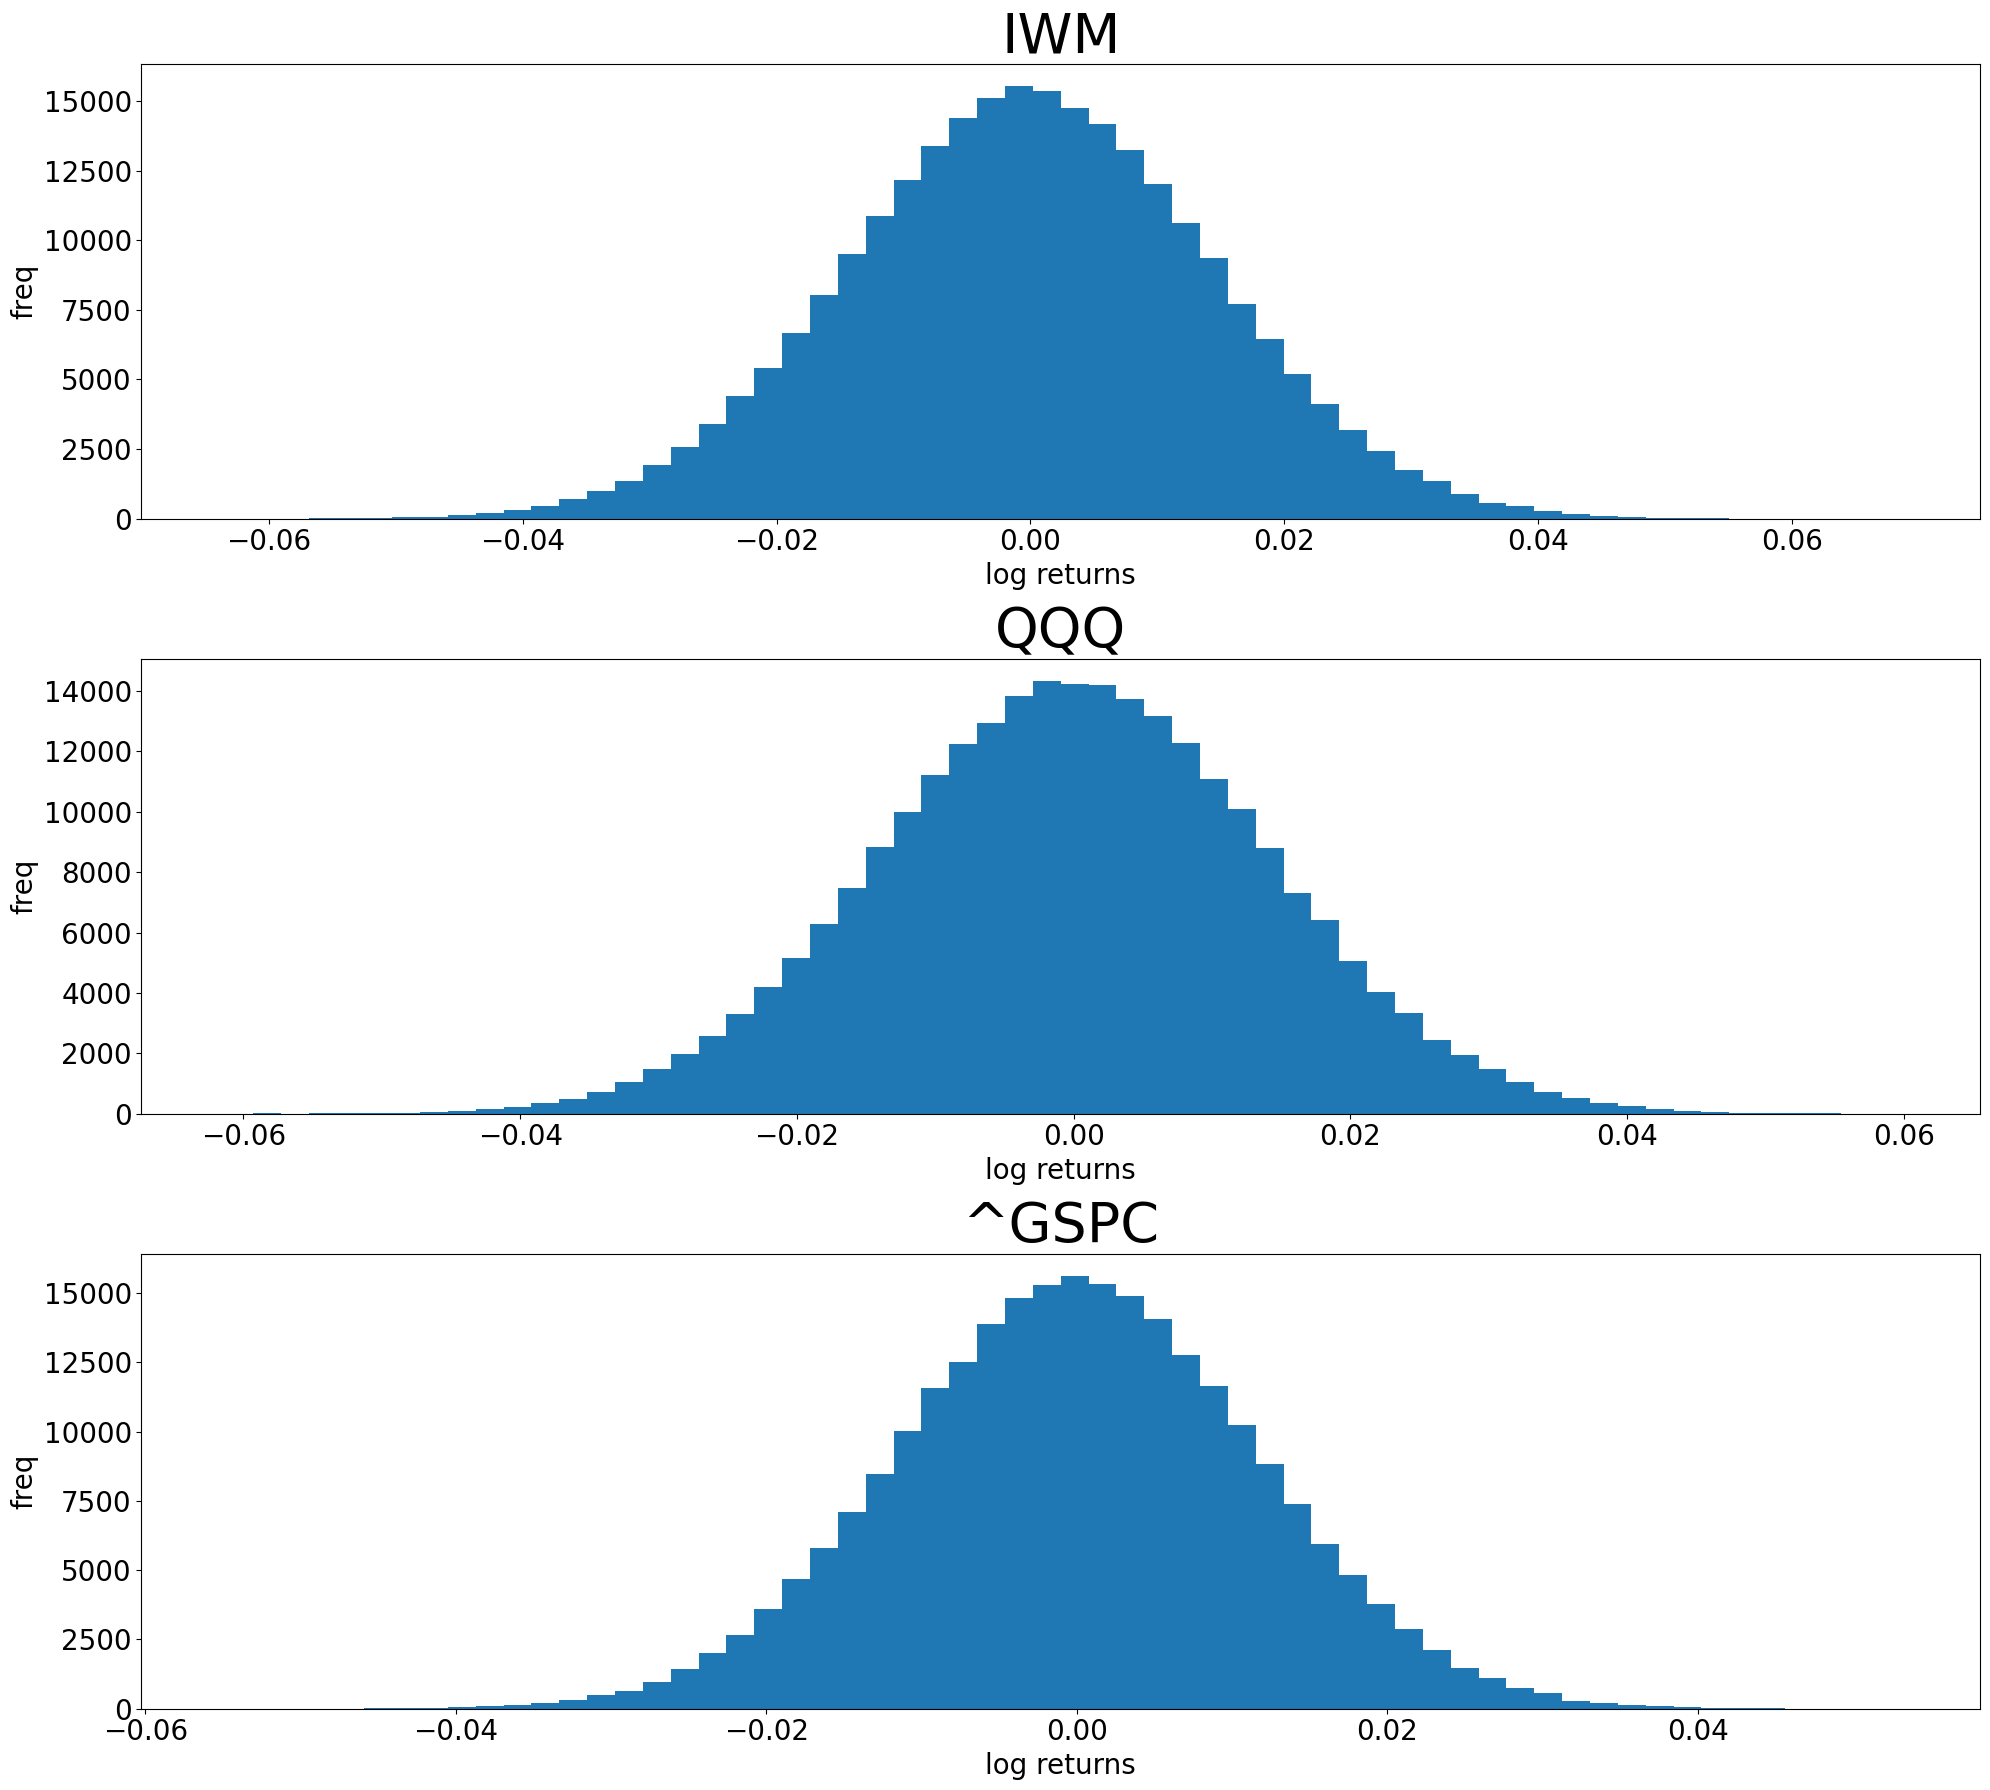

In [163]:
# Distribution of Stock returns

fig, ax = plt.subplots(3,1,figsize=(20,18))
for i in range(3):
    returns = np.log(S[i,1:]/S[i,:-1])
    ax[i].hist(returns.flatten(), bins=60)
    ax[i].set_xlabel('log returns',fontsize=20)
    ax[i].set_ylabel('freq',fontsize=20)
    ax[i].set_title(f'{mu.index[i]}',fontsize=40)
    print(f'{mu.index[i]}')
    print('mu = %.6f'%np.mean(returns))
    print('sigma = %.4f'%np.std(returns))
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    ax[i].tick_params(axis='both', which='minor', labelsize=20)
fig.tight_layout()



That allow us to compute the maximum loss for 2024 predicted with some confidence level. Let's say, that with 95% confidence, losses wont be higher than 1.65*sigma

In [166]:
p95=[]
for i in range(3):
    returns = np.log(S[i,1:]/S[i,:-1])
    print(f'for {mu.index[i]}, with a 95% confidence, losses wont be higher than {np.round(returns.mean()-1.65*returns.std(),4)}')
    p95.append(returns.mean()-1.65*returns.std())

for IWM, with a 95% confidence, losses wont be higher than -0.0237
for QQQ, with a 95% confidence, losses wont be higher than -0.0231
for ^GSPC, with a 95% confidence, losses wont be higher than -0.0191


Let's see actual losses

In [ ]:
# create DataFrames that store losses below the value computed with 95% confidence
df1 = rets['Adj Close']['IWM'].loc['2023-11-18':][rets['Adj Close']['IWM']<p95[0]]
df2 = rets['Adj Close']['QQQ'].loc['2023-11-18':][rets['Adj Close']['QQQ']<p95[1]]
df3 = rets['Adj Close']['^GSPC'].loc['2023-11-18':][rets['Adj Close']['^GSPC']<p95[2]]

In [ ]:
# concat in one DataFrame to analyze
df = pd.concat([df1, df2,df3],axis=1)
df

IWM       QQQ     ^GSPC
Date                                    
2024-01-03 -0.027026       NaN       NaN
2024-01-31 -0.024733       NaN       NaN
2024-02-13 -0.042011       NaN       NaN
2024-04-10 -0.026763       NaN       NaN
2024-07-17       NaN -0.029794       NaN
2024-07-24       NaN -0.036529 -0.023421
2024-08-01 -0.033061 -0.024520       NaN
2024-08-02 -0.036009 -0.024021       NaN
2024-08-05 -0.032694 -0.030270 -0.030427
2024-09-03 -0.031057 -0.030831 -0.021378
2024-09-06       NaN -0.027153       NaN
2024-10-31       NaN -0.025567       NaN
2024-11-15       NaN -0.024114       NaN

It can be seen that there were a couple of dates that were bad for all 3 tickers, such as '2024-08-05' and '2024-09-03'

In [205]:
for i in range(3):
    print(f'for {df.columns[i]}, actual losses were higher than computed {np.round(df[df.columns[i]].notna().sum()/252*100,2)}% of the times')

for IWM, actual losses were higher than computed 3.17% of the times
for QQQ, actual losses were higher than computed 3.57% of the times
for ^GSPC, actual losses were higher than computed 1.19% of the times


So that VaR computed this way worked pritty well, given that the actual losses.

Was risk over estimated due to COVID crisis? What if data would have been taken since 2021?

In [209]:
# are volatilities very different?
vol1 = rets['Adj Close'].loc[:'2023-11-18'].std()*np.sqrt(252) # 9 years of data
vol2 = rets['Adj Close'].loc['2021-01-04':'2023-11-18'].std()*np.sqrt(252) # after COVID
print(f'vol1 = {vol1}\nvol2 = {vol2}')

vol1 = Ticker
IWM      0.227724
QQQ      0.222865
^GSPC    0.184126
dtype: float64
vol2 = Ticker
IWM      0.236942
QQQ      0.241391
^GSPC    0.178696
dtype: float64


It was higher after COVID-19, meaning that before the COVID crisis, these tickers were less volatile than after. We can corroborate it with he simulation. And also was seen on revious vol's plots.

In [207]:
mu = rets['Adj Close'].loc['2021-01-04':'2023-11-18'].mean() # compute mean taken data until initial date for simulation
vol = rets['Adj Close'].loc['2021-01-04':'2023-11-18'].std()*np.sqrt(252) # compute annualized volatility taken data until initial date for simulation
T = 1 # number of years to simulate
M = T * 252 # number of BD to simulate
dt = T/M # year fraction
N = 1000 # number of simulation paths
S0 = data['Adj Close'].loc['2023-11-17'] # initial stock price
S = np.zeros((3, M+1, N)) # vector to save simulated paths
for i in range(3):
    S[i,0,:] = S0.iloc[i]*np.ones(N) # set initial value to spot 
    for t in range(1, M+1):
        dz = np.random.standard_normal(N)
        S[i,t,:] = S[i,t-1,:] * np.exp(mu.iloc[i] * dt + vol.iloc[i] * np.sqrt(dt)*dz) # considering vol and mu to be constant
p95=[]
for i in range(3):
    returns = np.log(S[i,1:]/S[i,:-1])
    print(f'for {mu.index[i]}, with a 95% confidence, losses wont be higher than {np.round(returns.mean()-1.65*returns.std(),4)}')
    p95.append(returns.mean()-1.65*returns.std())
# create DataFrames that store losses below the value computed with 95% confidence
df1 = rets['Adj Close']['IWM'].loc['2023-11-18':][rets['Adj Close']['IWM']<p95[0]]
df2 = rets['Adj Close']['QQQ'].loc['2023-11-18':][rets['Adj Close']['QQQ']<p95[1]]
df3 = rets['Adj Close']['^GSPC'].loc['2023-11-18':][rets['Adj Close']['^GSPC']<p95[2]]
# concat in one DataFrame to analyze
df = pd.concat([df1, df2,df3],axis=1)
for i in range(3):
    print(f'for {df.columns[i]}, actual losses were higher than computed {np.round(df[df.columns[i]].notna().sum()/252*100,2)}% of the times')

for IWM, with a 95% confidence, losses wont be higher than -0.0246
for QQQ, with a 95% confidence, losses wont be higher than -0.025
for ^GSPC, with a 95% confidence, losses wont be higher than -0.0186
for IWM, actual losses were higher than computed 3.17% of the times
for QQQ, actual losses were higher than computed 2.38% of the times
for ^GSPC, actual losses were higher than computed 1.59% of the times


It wasn't, given that taken into account data after COVID crisis, the VaR estimation worked properly for the last year. 

What would have been the results if we were used historical method?

In [216]:
ser1 = rets.loc[:'2023-11-18']['Adj Close']['IWM'].sort_values()
var1 = ser1.iloc[int(len(ser1)*5/100)]
ser2 = rets.loc[:'2023-11-18']['Adj Close']['QQQ'].sort_values()
var2 = ser2.iloc[int(len(ser2)*5/100)]
ser3 = rets.loc[:'2023-11-18']['Adj Close']['^GSPC'].sort_values()
var3 = ser3.iloc[int(len(ser3)*5/100)]

varh = [var1, var2, var3]

p95=[]
for i in range(3):
    print(f'for {mu.index[i]}, with a 95% confidence, losses wont be higher than {np.round(varh[i],4)}')
    p95.append(varh[i])
# create DataFrames that store losses below the value computed with 95% confidence
df1 = rets['Adj Close']['IWM'].loc['2023-11-18':][rets['Adj Close']['IWM']<p95[0]]
df2 = rets['Adj Close']['QQQ'].loc['2023-11-18':][rets['Adj Close']['QQQ']<p95[1]]
df3 = rets['Adj Close']['^GSPC'].loc['2023-11-18':][rets['Adj Close']['^GSPC']<p95[2]]
# concat in one DataFrame to analyze
df = pd.concat([df1, df2,df3],axis=1)
for i in range(3):
    print(f'for {df.columns[i]}, actual losses were higher than computed {np.round(df[df.columns[i]].notna().sum()/252*100,2)}% of the times')

for IWM, with a 95% confidence, losses wont be higher than -0.0218
for QQQ, with a 95% confidence, losses wont be higher than -0.0231
for ^GSPC, with a 95% confidence, losses wont be higher than -0.0174
for IWM, actual losses were higher than computed 3.17% of the times
for QQQ, actual losses were higher than computed 3.57% of the times
for ^GSPC, actual losses were higher than computed 1.98% of the times


Historical VaR also worked.

Another way to compute VaR with MC sim

In [240]:
p95 = []
for i in range(3):
    ss = sorted(S[i,-1,:]) # get the last value of each simulation path
    wl = ss[int(N*5/100)]/S0.iloc[i]-1 # take the 5% worth loss
    print(f'for {mu.index[i]}, with a 95% confidence, losses wont be higher than {np.round(wl,4)}')
    p95.append(wl)
# create DataFrames that store losses below the value computed with 95% confidence
df1 = rets['Adj Close']['IWM'].loc['2023-11-18':][rets['Adj Close']['IWM']<p95[0]]
df2 = rets['Adj Close']['QQQ'].loc['2023-11-18':][rets['Adj Close']['QQQ']<p95[1]]
df3 = rets['Adj Close']['^GSPC'].loc['2023-11-18':][rets['Adj Close']['^GSPC']<p95[2]]
# concat in one DataFrame to analyze
df = pd.concat([df1, df2,df3],axis=1)
for i in range(3):
    print(f'for {df.columns[i]}, actual losses were higher than computed {np.round(df[df.columns[i]].notna().sum()/252*100,2)}% of the times')

for IWM, with a 95% confidence, losses wont be higher than -0.3183
for QQQ, with a 95% confidence, losses wont be higher than -0.3263
for ^GSPC, with a 95% confidence, losses wont be higher than -0.2611
for IWM, actual losses were higher than computed 0.0% of the times
for QQQ, actual losses were higher than computed 0.0% of the times
for ^GSPC, actual losses were higher than computed 0.0% of the times


In [238]:
S0.iloc[0]

176.0946502685547

In [237]:
sorted(S[0,-1,:])

[82.80360582277358,
 85.06868028101822,
 87.25648743627275,
 89.33313481553199,
 90.40538250045834,
 92.4062234110987,
 95.76778456361536,
 96.5147290385867,
 97.28127340657451,
 97.8802352008438,
 98.40734501298186,
 99.40791696300363,
 100.32494796308623,
 102.05418861878294,
 102.29423267239827,
 102.50888252566672,
 103.80808168428018,
 103.8574287727179,
 103.89208103760197,
 104.85115495356418,
 105.69800220163123,
 105.7129779158293,
 106.21384401042359,
 106.26258593254762,
 106.6348283932839,
 107.89011556973061,
 107.91982605687261,
 108.44680934634616,
 109.46356556626029,
 109.54111424071769,
 110.72796343919086,
 111.25165940577438,
 112.21490261620819,
 113.13060170658464,
 113.79038772967792,
 113.98574607232965,
 114.3911325323923,
 114.6783083002196,
 114.77647072633118,
 114.85291215566039,
 115.29780190547841,
 115.81007282637096,
 116.04242044129151,
 116.7385483793235,
 116.7904324674374,
 117.48367695657825,
 117.75696413529936,
 118.6813162419867,
 119.3104509794

In [136]:
np.shape(S[:,0,:])

(3, 1000)

In [68]:
corrdf=pd.DataFrame()
corrdf['corr']=rets['Adj Close']['QQQ'].rolling(window=20).corr(rets['Adj Close']['IWM'])
corrdf


corr
Date                
2014-11-20       NaN
2014-11-21       NaN
2014-11-24       NaN
2014-11-25       NaN
2014-11-26       NaN
...              ...
2024-11-12  0.612860
2024-11-13  0.634755
2024-11-14  0.648177
2024-11-15  0.668701
2024-11-18  0.689927

[2515 rows x 1 columns]

In [69]:
# merge with actual data for backtesting
df3 = pd.merge(corrdf, df2, how='inner', right_on='dates', left_index=True)
df3 = pd.merge(rets['Adj Close'].QQQ, df3, how='inner', right_on='dates', left_index=True)
df3.head()

QQQ      corr       IWM      dates  bs    y_pred
0  0.004653  0.820812  0.012940 2024-08-21  -1 -0.029507
1 -0.015982  0.869454 -0.008857 2024-08-22  -1 -0.025726
2  0.010787  0.843016  0.031436 2024-08-23   1  0.103531
3 -0.009756  0.840226  0.000318 2024-08-26   1  0.043257
4  0.002983  0.863921 -0.007787 2024-08-27   1  0.031525

In [70]:
df3['B&H'] = df3.QQQ+df3['corr']*df3.IWM
df3['S1'] = df3.QQQ*df3.bs+df3['corr']*df3.IWM*df3.bs

this stratgy outperforms the Buy&Hols Strategy for IWM during 8-21-2024 
and 11-13-2024 by 8%


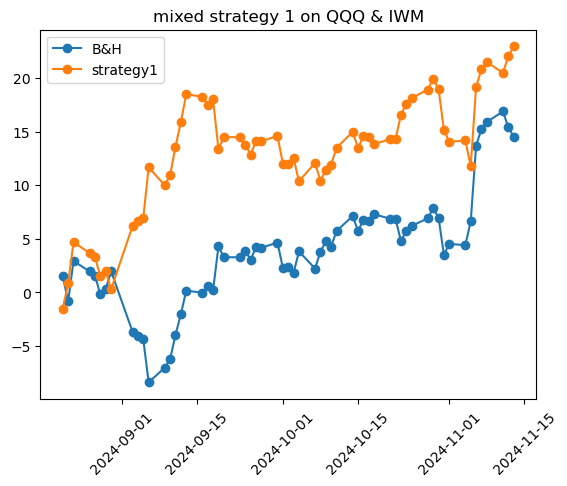

In [71]:
# plot results
plt.plot(df3.dates,100*(df3['B&H'].cumsum().apply('exp')-1),marker='o',label='B&H')
plt.plot(df3.dates,100*(df3['S1'].cumsum().apply('exp')-1),marker='o',label='strategy1')
plt.xticks(rotation=45)
plt.title(f'mixed strategy 1 on QQQ & IWM')
plt.legend()

outp = df3['S1'].cumsum().apply('exp').iloc[-1]-df3['B&H'].cumsum().apply('exp').iloc[-1]
print(f'this stratgy outperforms the Buy&Hols Strategy for {tick} during {df3.dates.iloc[0].month}-{df3.dates.iloc[0].day}-{df2.dates.iloc[0].year} \nand {df2.dates.iloc[-1].month}-{df2.dates.iloc[-1].day}-{df2.dates.iloc[-1].year} by {int(outp*100)}%')

# Appendix

Exclude COVID period too see if it improves performance.

In [72]:
period = 5 # amount of forecasting Bdays
df = pd.DataFrame() # create a DF with Prophet's requirements
df['ds'] = data['Adj Close'].loc['2021-01-04':].QQQ.index[:-period] # column of dates named 'ds'
df['y'] = data['Adj Close'].loc['2021-01-04':].QQQ.values[:-period] # column of values named 'y'
df.index = df.ds # set index as dates
df = df.asfreq('B', method='pad') # set freq as BD 
df.tail()

ds           y
ds                               
2024-11-05 2024-11-05  492.209991
2024-11-06 2024-11-06  505.579987
2024-11-07 2024-11-07  513.539978
2024-11-08 2024-11-08  514.140015
2024-11-11 2024-11-11  513.840027

### fit

In [73]:
atdim = 21 # average amount of trading days in a month
m = Prophet(changepoint_prior_scale = 0.05,
            weekly_seasonality = True,
            daily_seasonality = False,
            yearly_seasonality = True,
            changepoints = None)
m.add_seasonality(name='monthly',period=atdim,fourier_order=5)
m.fit(df)

11:24:07 - cmdstanpy - INFO - Chain [1] start processing
11:24:07 - cmdstanpy - INFO - Chain [1] done processing


### make predictions

In [74]:
future = m.make_future_dataframe(periods=period,freq='B') # make df with future dates
future.tail()

ds
971 2024-11-12
972 2024-11-13
973 2024-11-14
974 2024-11-15
975 2024-11-18

In [75]:
forecast = m.predict(future) # make predictions on future dates
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
971 2024-11-12  501.893941  488.649166  515.032440
972 2024-11-13  503.399969  490.587155  517.368581
973 2024-11-14  504.509786  491.242121  518.100179
974 2024-11-15  504.736875  491.097660  518.047389
975 2024-11-18  507.169996  493.037455  520.493708

### plot forecast

/home/flor/anaconda3/envs/env2/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/flor/anaconda3/envs/env2/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



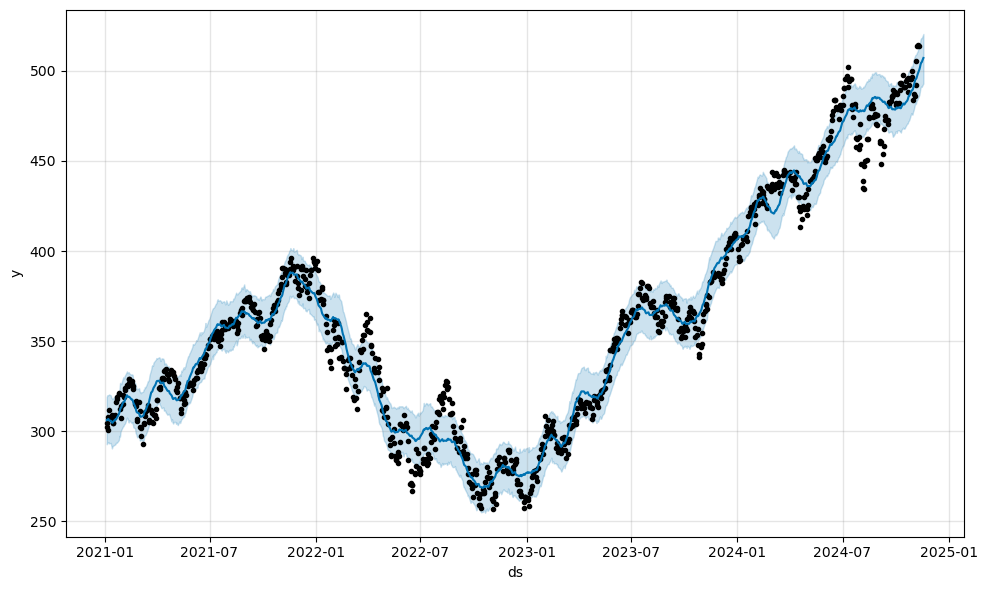

In [76]:
fig1 = m.plot(forecast)

### backtesting: merge fit & forecast with actual data

In [77]:
df2 = pd.merge(data['Adj Close'].QQQ, forecast, how='inner', right_on='ds', left_index=True)
df2.head()

QQQ         ds       trend  yhat_lower  yhat_upper  trend_lower  \
0  302.171936 2021-01-04  304.256750  292.730874  318.938780   304.256750   
1  304.663025 2021-01-05  304.431552  293.119092  319.939408   304.431552   
2  300.442749 2021-01-06  304.606354  293.830529  319.995286   304.606354   
3  307.711029 2021-01-07  304.781156  293.900501  319.959512   304.781156   
4  311.667664 2021-01-08  304.955958  293.180026  320.380734   304.955958   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   304.256750        1.818590              1.818590              1.818590   
1   304.431552        1.746893              1.746893              1.746893   
2   304.606354        2.024363              2.024363              2.024363   
3   304.781156        1.932552              1.932552              1.932552   
4   304.955958        0.996371              0.996371              0.996371   

   ...    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0  ...  1.603739      1.603739      1.603739  1.029584      1.029584   
1  ...  0.517507      0.517507      0.517507  0.704186      0.704186   
2  ...  0.009172      0.009172      0.009172  0.368766      0.368766   
3  ...  0.488204      0.488204      0.488204  0.029840      0.029840   
4  ...  1.395370      1.395370      1.395370 -0.305501     -0.305501   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0      1.029584                   0.0                         0.0   
1      0.704186                   0.0                         0.0   
2      0.368766                   0.0                         0.0   
3      0.029840                   0.0                         0.0   
4     -0.305501                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  306.075340  
1                         0.0  306.178445  
2                         0.0  306.630717  
3                         0.0  306.713708  
4                         0.0  305.952329  

[5 rows x 23 columns]

### plot forecast vs actual

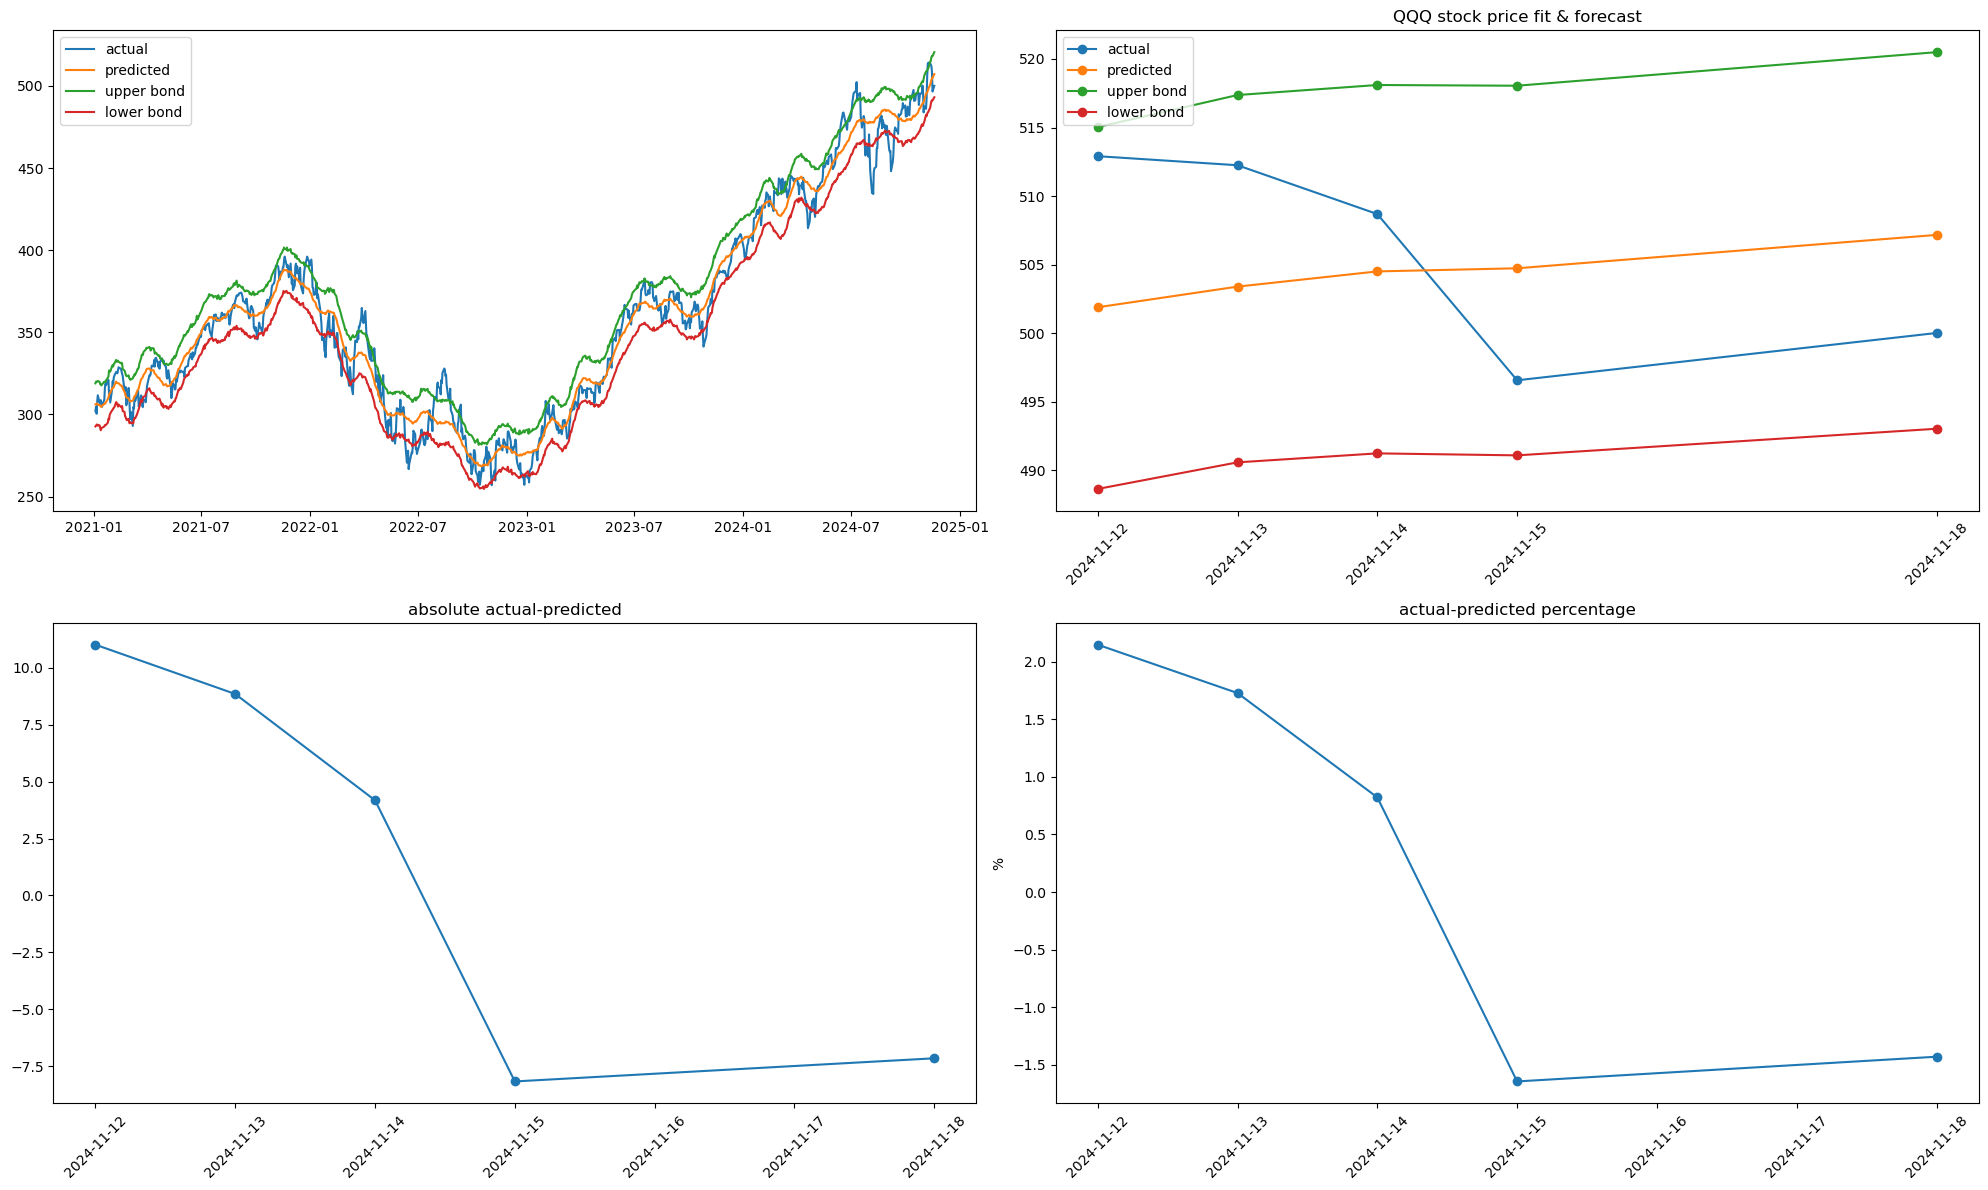

In [78]:
fig, axs = plt.subplots(2,2, figsize = (20,12))

axs[0,1].plot(df2.ds[-period:], df2.QQQ[-period:], marker='o', label='actual')
axs[0,1].plot(df2.ds[-period:], df2.yhat[-period:],  marker='o',label='predicted')
axs[0,1].plot(df2.ds[-period:], df2.yhat_upper[-period:], marker='o', label='upper bond')
axs[0,1].plot(df2.ds[-period:], df2.yhat_lower[-period:], marker='o', label='lower bond')
axs[0,1].set_xticks(df2.ds[-period:])
axs[0,1].set_title('QQQ stock price forecast')
axs[0,1].tick_params('x',labelrotation=45)
axs[0,1].legend()

axs[0,0].plot(df2.ds, df2.QQQ, label='actual')
axs[0,0].plot(df2.ds, df2.yhat, label='predicted')
axs[0,0].plot(df2.ds, df2.yhat_upper, label='upper bond')
axs[0,0].plot(df2.ds, df2.yhat_lower, label='lower bond')
axs[0,1].set_title('QQQ stock price fit & forecast')
axs[0,0].legend()

labels=df2.ds[-5:]
axs[1,0].plot(df2.ds[-period:], df2.QQQ[-period:]-df2.yhat[-period:],marker='o', label='actual-predicted')
axs[1,0].set_title('absolute actual-predicted')
axs[1,0].tick_params('x',labelrotation=45)

axs[1,1].plot(df2.ds[-period:], (df2.QQQ[-period:]-df2.yhat[-period:])/df2.QQQ[-period:] *100,marker='o', label='actual-predicted %')
axs[1,1].set_title('actual-predicted percentage')
axs[1,1].tick_params('x',labelrotation=45)
axs[1,1].set_ylabel('%')
fig.tight_layout()

## ARIMA

In [79]:
rc = rets['Adj Close'].QQQ.copy().dropna()[:-20]
rc = rc.asfreq('B')

In [80]:
# Fit ARIMA model

mod = ARIMA(rc, order=(2,0,1))
mod_fit = mod.fit()

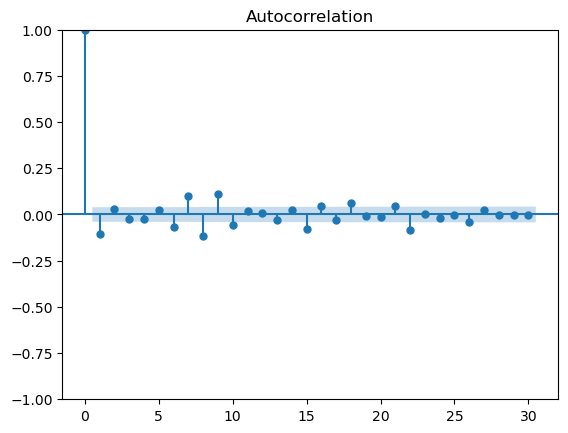

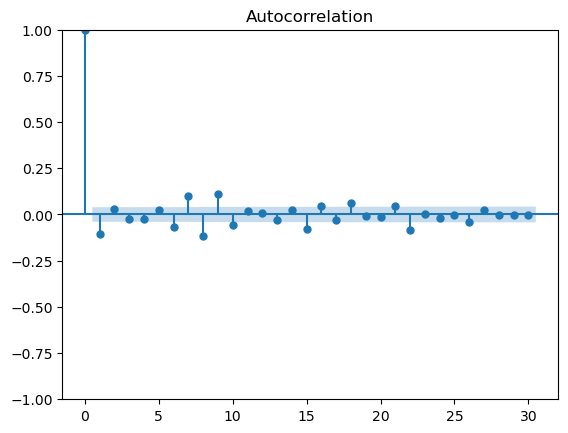

In [81]:
plot_acf(rc.dropna(),lags=30)

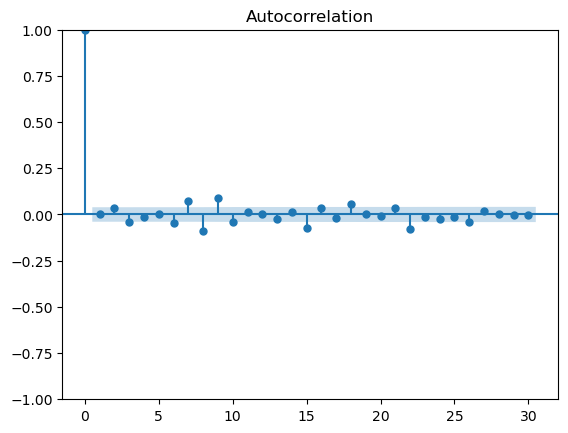

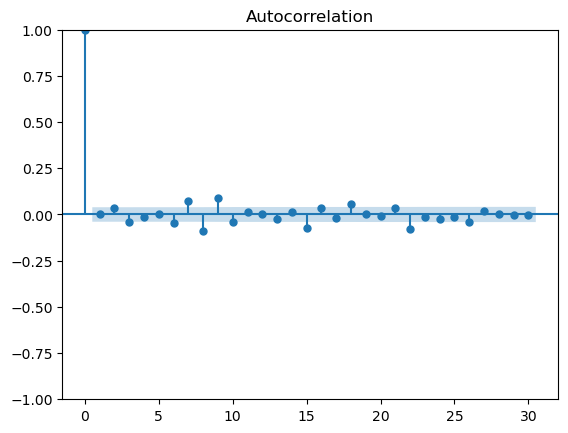

In [82]:
plot_acf(mod_fit.resid.dropna(),lags=30)

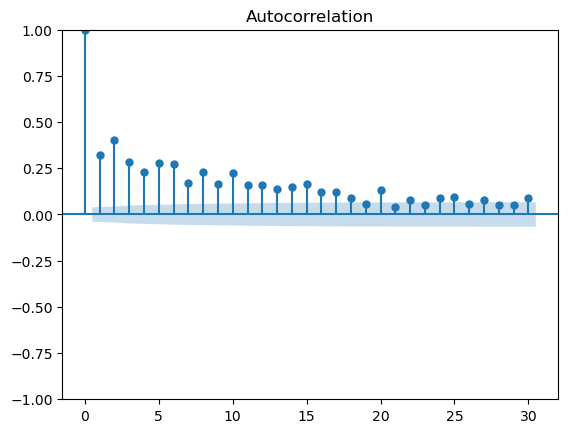

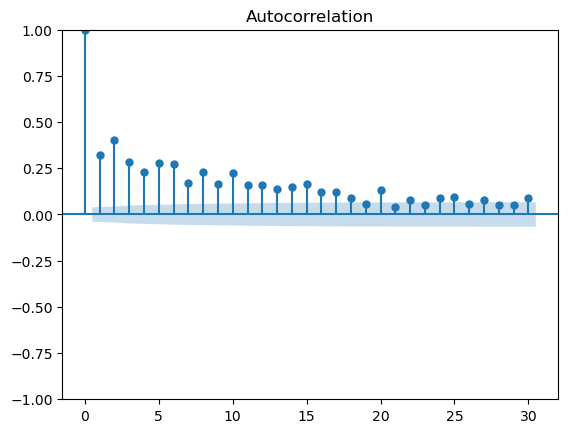

In [83]:
plot_acf((mod_fit.resid.dropna())**2,lags=30)

In [84]:
# Calculate the performance metrics
mse = mean_squared_error(data['Adj Close'].QQQ.copy()[-20:], forecast)
mae = mean_absolute_error(data['Adj Close'].QQQ.copy()[-20:], forecast)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

ValueError: Found input variables with inconsistent numbers of samples: [20, 976]

In [ ]:
mod_fit.aic

np.float64(-14328.476317267208)

Look for the best arima parameters

In [ ]:
#mod = ARIMA(rc, order=(2,0,1))
#mod_fit = mod.fit()
finalaic = np.inf
for p in range(1,5):
    for q in range(1,5):
        currentaic = ARIMA(rc, order=(p, 0, q)).fit().aic
        if currentaic < finalaic: 
            finalaic = currentaic
            finalorder = (p, 0, q)
            finalarima = ARIMA(rc, order=finalorder)

/home/florencia/anaconda3/envs/fsa_v2_lib/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/florencia/anaconda3/envs/fsa_v2_lib/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/florencia/anaconda3/envs/fsa_v2_lib/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/florencia/anaconda3/envs/fsa_v2_lib/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/florencia/anaconda3/envs/fsa_v2_lib/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting 

In [ ]:
print('finalorder: ',finalorder)

finalorder:  (2, 0, 1)


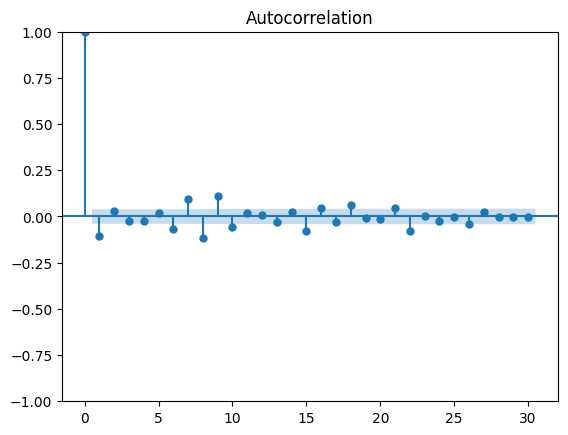

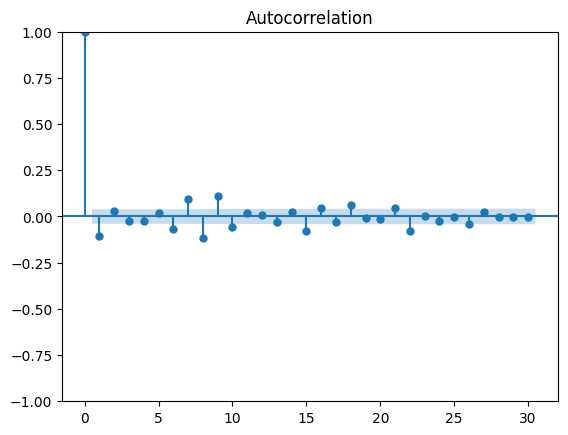

In [ ]:
plot_acf(rets['Adj Close'].QQQ,lags=30)

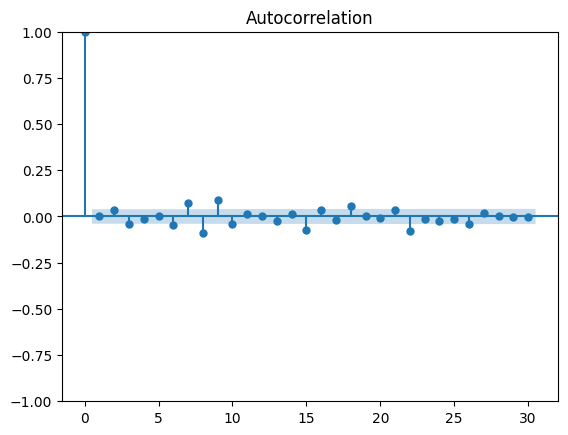

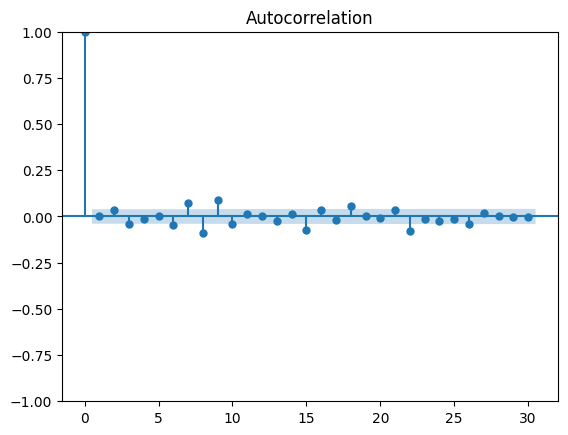

In [ ]:
plot_acf(finalarima.fit().resid.dropna(),lags=30)

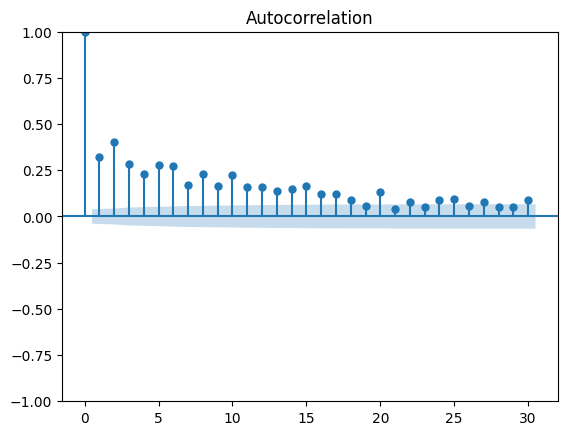

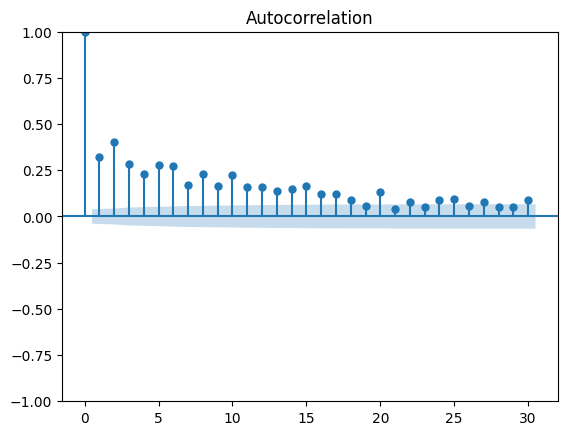

In [ ]:
plot_acf((finalarima.fit().resid.dropna())**2,lags=30)

In [ ]:
am = arch_model(finalarima.fit().resid.dropna(),mean='Zero',vol='GARCH',p=2,q=1)
res = am.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -7570.712905593055
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7570.712911710677
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


/home/florencia/anaconda3/envs/fsa_v2_lib/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001869. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [ ]:
predicted_mu = finalarima

(4, 4)

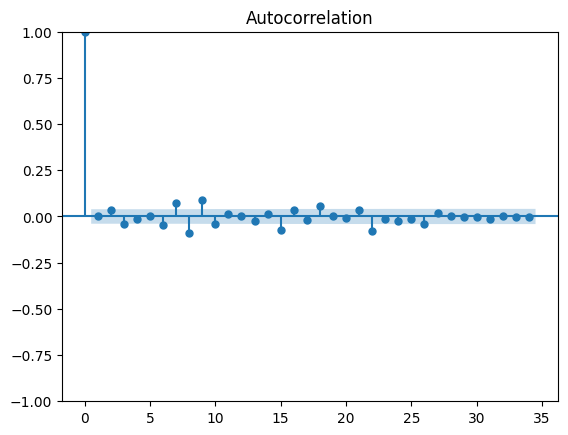

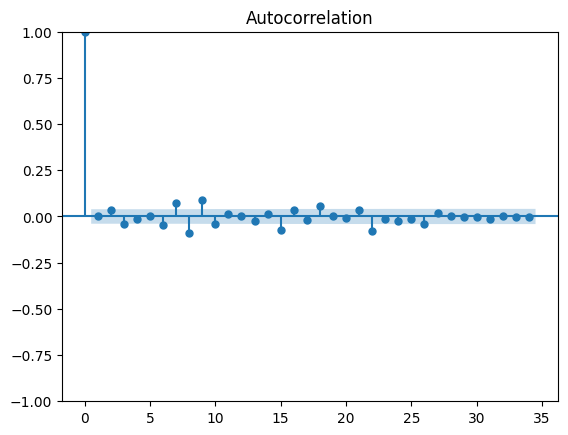

In [ ]:
plot_acf(res.resid)

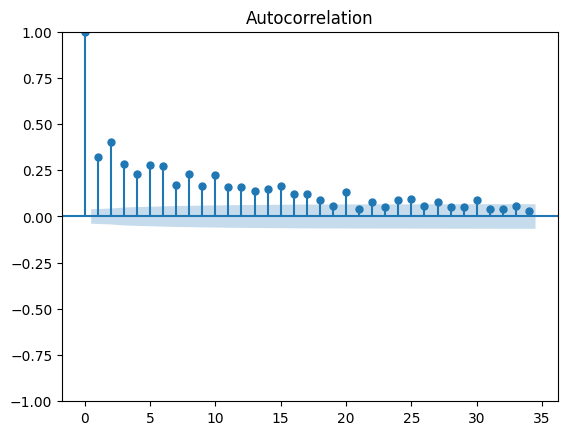

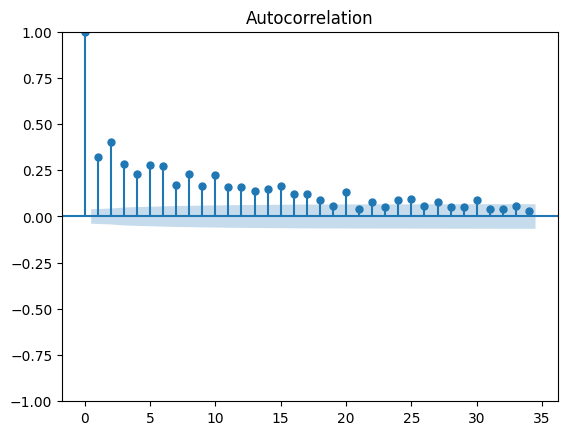

In [ ]:
plot_acf(res.resid**2)

In [ ]:
res.summary

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7570.71
Distribution:                  Normal   AIC:                          -15133.4
Method:            Maximum Likelihood   BIC:                          -15110.1
                                        No. Observations:                 2495
Date:                Tue, Nov 26 2024   Df Residuals:                     2495
Time:                        16:08:11   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.7386

## random forest

Mean Squared Error (Random Forest): 0.00014672386997713447
Mean Squared Error on cumulative returns (Random Forest): 0.04613655704394494


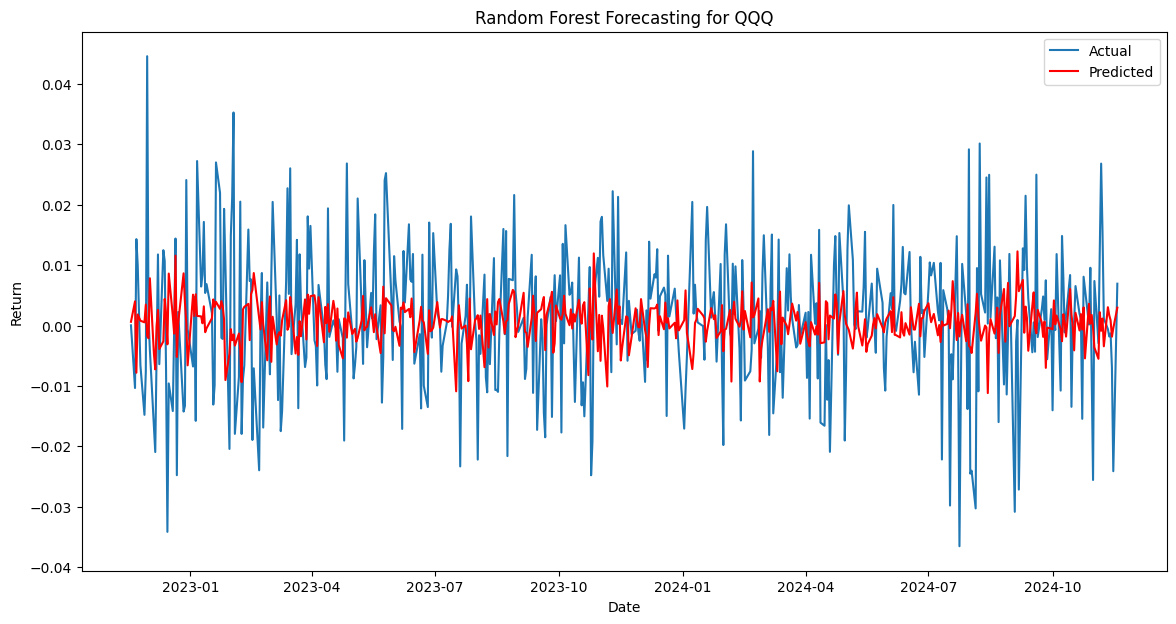

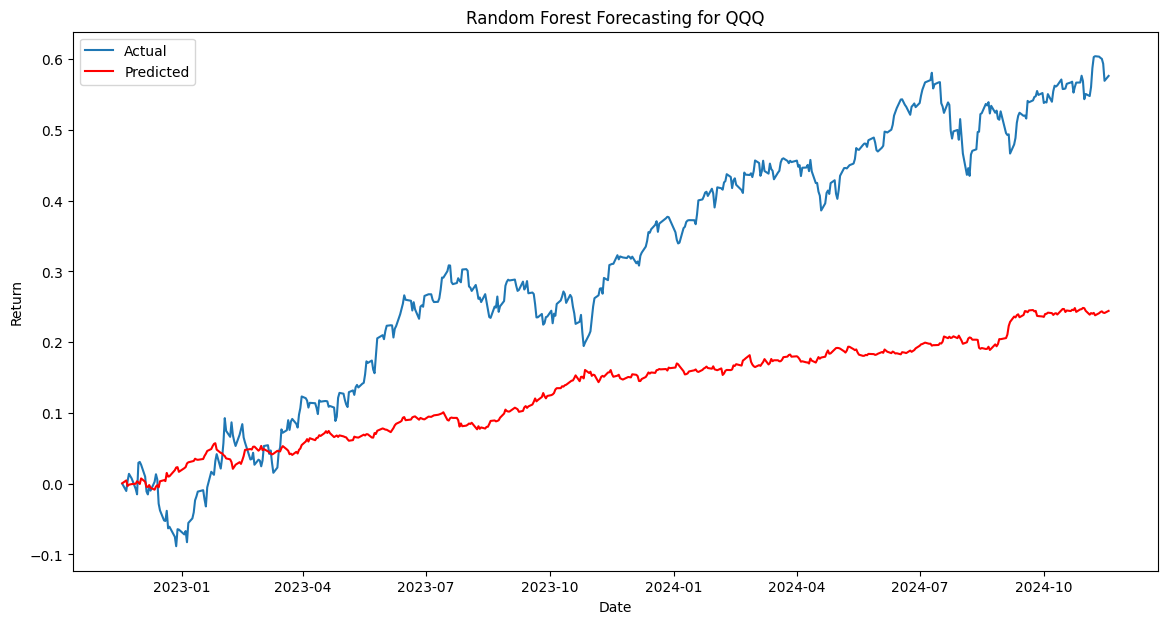

In [ ]:
# Create lagged features for Random Forest
data2 = rets['Adj Close'].copy()
data2['Lag_1'] = data2['QQQ'].shift(1)
data2['Lag_2'] = data2['QQQ'].shift(2)
data2['Lag_3'] = data2['QQQ'].shift(3)
data2['Lag_4'] = data2['QQQ'].shift(4)
data2['Lag_5'] = data2['QQQ'].shift(5)
#data2['Lag_20'] = data2['QQQ'].shift(20)
data2.dropna(inplace=True)

# Define features and target
X = data2[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']]
y = data2['QQQ']

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate and print the mean squared error
mse_rf = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Random Forest): {mse_rf}')

# Calculate and print the mean squared error on cumulative returns
mse_rf = mean_squared_error(y_test.cumsum(), y_pred.cumsum())
print(f'Mean Squared Error on cumulative returns (Random Forest): {mse_rf}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.title('Random Forest Forecasting for QQQ')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.savefig('QQQ_RFRegressor.png')

plt.show()

# Plot the actual vs predicted values cumsum
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.cumsum(), label='Actual')
plt.plot(y_test.index, y_pred.cumsum(), label='Predicted', color='red')
plt.title('Random Forest Forecasting for QQQ')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.savefig('QQQ_RFRegressor.png')

plt.show()

## Long Short-Term Memory

Epoch 1/10


2024-11-26 15:48:14.454000: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/florencia/anaconda3/envs/fsa_v2_lib/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



32/32 - 3s - 101ms/step - loss: 0.0206
Epoch 2/10
32/32 - 0s - 10ms/step - loss: 5.9504e-04
Epoch 3/10
32/32 - 0s - 10ms/step - loss: 2.2740e-04
Epoch 4/10
32/32 - 0s - 11ms/step - loss: 2.0739e-04
Epoch 5/10
32/32 - 0s - 11ms/step - loss: 2.0047e-04
Epoch 6/10
32/32 - 0s - 11ms/step - loss: 1.9292e-04
Epoch 7/10
32/32 - 0s - 11ms/step - loss: 1.8564e-04
Epoch 8/10
32/32 - 1s - 19ms/step - loss: 1.8197e-04
Epoch 9/10
32/32 - 0s - 10ms/step - loss: 1.8107e-04
Epoch 10/10
32/32 - 0s - 10ms/step - loss: 1.8627e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


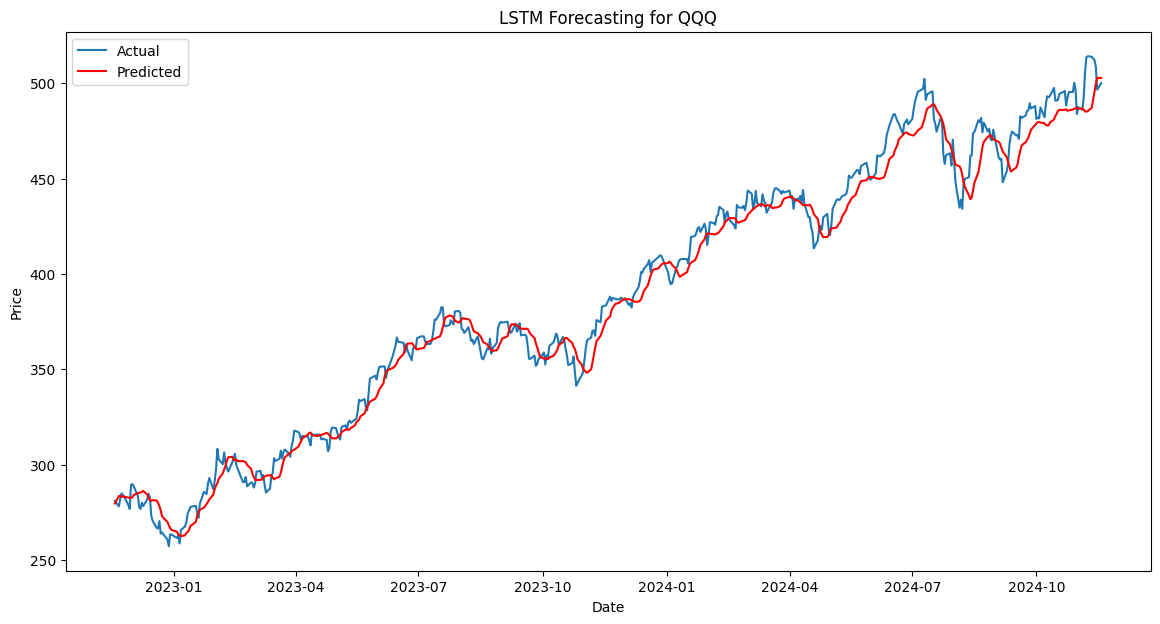

Mean Squared Error (LSTM): 83.66657096464786


In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data['Adj Close']['QQQ'].values.reshape(-1, 1))

# Create the dataset with a specific lookback period
lookback = 7
X_lstm, y_lstm = [], []
for i in range(lookback, len(data_scaled)):
    X_lstm.append(data_scaled[i-lookback:i, 0])
    y_lstm.append(data_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Reshape X to be [samples, time steps, features] which is required for LSTM
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# Split into train and test sets
train_size = int(len(X_lstm) * 0.8)
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=64, verbose=2)

# Predict on the test set
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(data.index[-len(y_test):], y_pred_lstm, label='Predicted', color='red')
plt.title('LSTM Forecasting for QQQ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('QQQ_LSTM.png')

plt.show()

# Calculate and print the mean squared error
mse_LSTM = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_lstm)
print(f'Mean Squared Error (LSTM): {mse_LSTM}')

excluding COVID

Epoch 1/10


/home/florencia/anaconda3/envs/fsa_v2_lib/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 - 3s - 236ms/step - loss: 0.0608
Epoch 2/10
13/13 - 0s - 12ms/step - loss: 0.0086
Epoch 3/10
13/13 - 0s - 12ms/step - loss: 0.0049
Epoch 4/10
13/13 - 0s - 12ms/step - loss: 0.0025
Epoch 5/10
13/13 - 0s - 12ms/step - loss: 0.0015
Epoch 6/10
13/13 - 0s - 12ms/step - loss: 0.0013
Epoch 7/10
13/13 - 0s - 12ms/step - loss: 0.0013
Epoch 8/10
13/13 - 0s - 12ms/step - loss: 0.0012
Epoch 9/10
13/13 - 0s - 13ms/step - loss: 0.0012
Epoch 10/10
13/13 - 0s - 12ms/step - loss: 0.0012
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


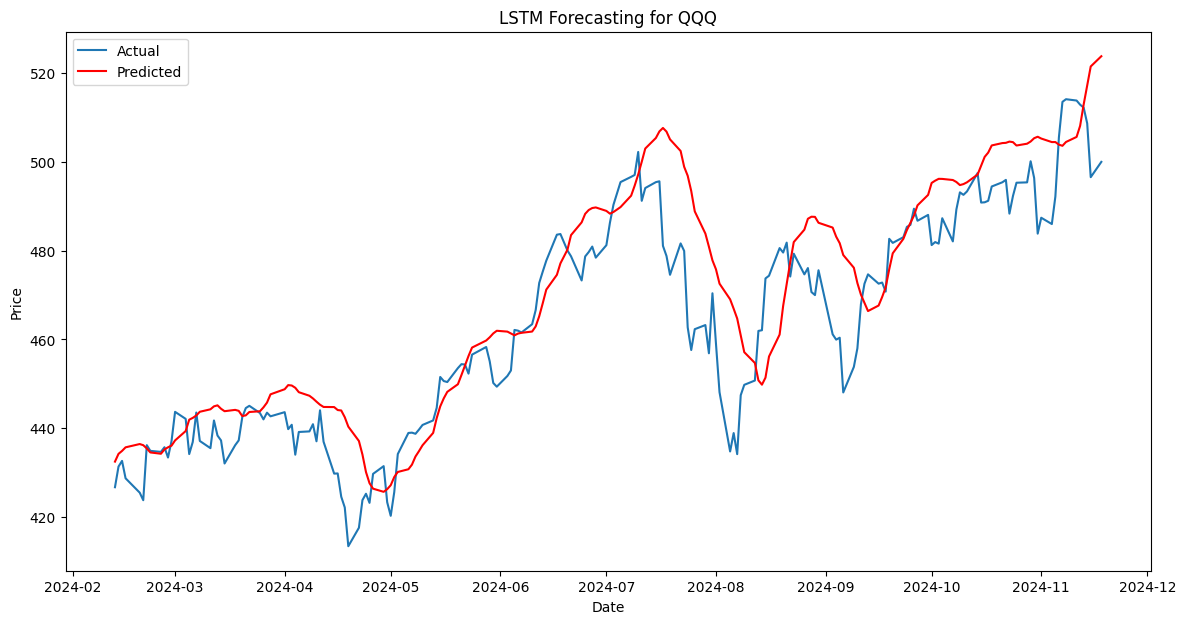

Mean Squared Error (LSTM): 150.0313049898742


In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.loc['2021-01-04':]['Adj Close']['QQQ'].values.reshape(-1, 1))

# Create the dataset with a specific lookback period
lookback = 8
X_lstm, y_lstm = [], []
for i in range(lookback, len(data_scaled)):
    X_lstm.append(data_scaled[i-lookback:i, 0])
    y_lstm.append(data_scaled[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Reshape X to be [samples, time steps, features] which is required for LSTM
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# Split into train and test sets
train_size = int(len(X_lstm) * 0.8)
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=64, verbose=2)

# Predict on the test set
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(data.index[-len(y_test):], y_pred_lstm, label='Predicted', color='red')
plt.title('LSTM Forecasting for QQQ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('QQQ_LSTM.png')

plt.show()

# Calculate and print the mean squared error
mse_LSTM = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_lstm)
print(f'Mean Squared Error (LSTM): {mse_LSTM}')

## PROPHET
### make 1Y predictions

In [ ]:
future = m.make_future_dataframe(periods=365,freq='D')
future.tail()

ds
2623 2024-11-11
2624 2024-11-12
2625 2024-11-13
2626 2024-11-14
2627 2024-11-15

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
2623 2024-11-11  1.271160    1.113976    1.440608
2624 2024-11-12  1.270748    1.105506    1.435575
2625 2024-11-13  1.270167    1.110795    1.418673
2626 2024-11-14  1.272051    1.109772    1.444515
2627 2024-11-15  1.268967    1.108233    1.428285

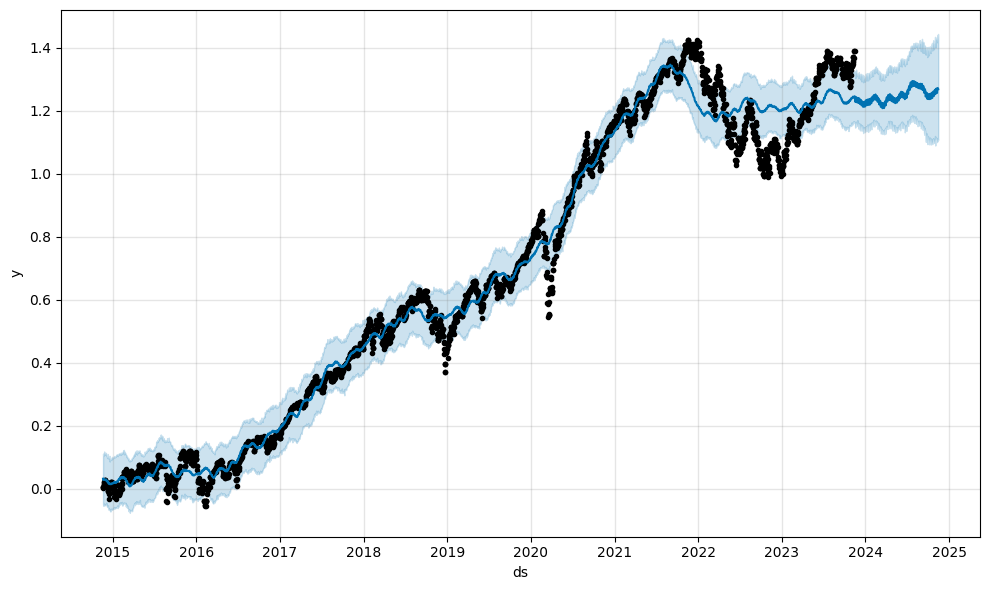

In [ ]:
fig1 = m.plot(forecast)

### test forecast

In [ ]:
df2 = pd.merge(rets['Adj Close'].QQQ.cumsum(), forecast, how='inner', right_on='ds', left_index=True)
df2.head()

QQQ         ds     trend  yhat_lower  yhat_upper  trend_lower  \
0  0.004447 2014-11-20  0.023966   -0.047490    0.111862     0.023966   
1  0.006374 2014-11-21  0.024041   -0.053732    0.104765     0.024041   
2  0.014142 2014-11-24  0.024267   -0.052579    0.113302     0.024267   
3  0.015670 2014-11-25  0.024342   -0.046446    0.118865     0.024342   
4  0.022135 2014-11-26  0.024417   -0.049608    0.114510     0.024417   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     0.023966        0.008524              0.008524              0.008524   
1     0.024041        0.004444              0.004444              0.004444   
2     0.024267        0.005504              0.005504              0.005504   
3     0.024342        0.006110              0.006110              0.006110   
4     0.024417        0.006824              0.006824              0.006824   

   ...    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0  ...  0.005996      0.005996      0.005996  0.003727      0.003727   
1  ...  0.002240      0.002240      0.002240  0.003517      0.003517   
2  ...  0.003608      0.003608      0.003608  0.002651      0.002651   
3  ...  0.003845      0.003845      0.003845  0.002283      0.002283   
4  ...  0.004003      0.004003      0.004003  0.001876      0.001876   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0      0.003727                   0.0                         0.0   
1      0.003517                   0.0                         0.0   
2      0.002651                   0.0                         0.0   
3      0.002283                   0.0                         0.0   
4      0.001876                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0  0.032490  
1                         0.0  0.028484  
2                         0.0  0.029771  
3                         0.0  0.030452  
4                         0.0  0.031242  

[5 rows x 23 columns]

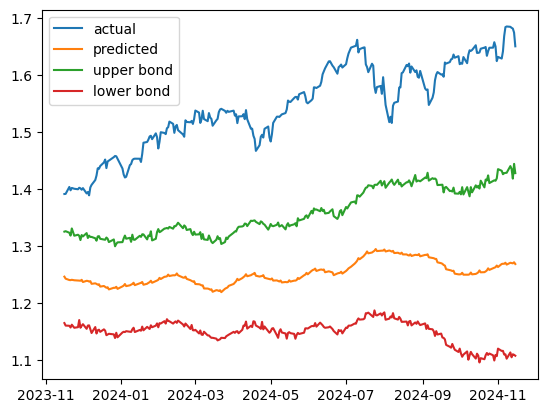

In [ ]:
plt.plot(df2.ds[-252:], df2.QQQ[-252:], label='actual')
plt.plot(df2.ds[-252:], df2.yhat[-252:], label='predicted')
plt.plot(df2.ds[-252:], df2.yhat_upper[-252:], label='upper bond')
plt.plot(df2.ds[-252:], df2.yhat_lower[-252:], label='lower bond')
plt.legend()

The prediction are way lower than the actual cumulative returns.

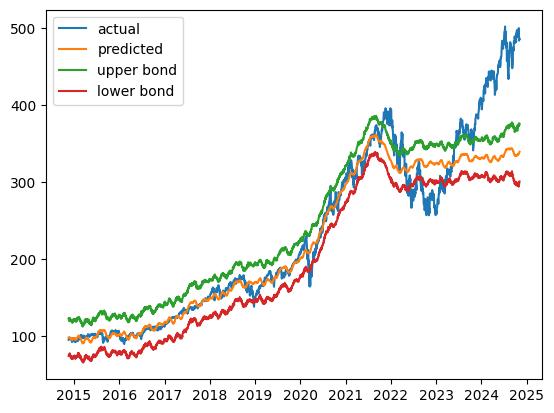

In [ ]:
plt.plot(df2.ds, df2.QQQ, label='actual')
plt.plot(df2.ds, df2.yhat, label='predicted')
plt.plot(df2.ds, df2.yhat_upper, label='upper bond')
plt.plot(df2.ds, df2.yhat_lower, label='lower bond')
plt.legend()

In [ ]:
df.tail()

ds           y
2259 2023-11-10  375.812500
2260 2023-11-13  374.640472
2261 2023-11-14  382.705200
2262 2023-11-15  382.993225
2263 2023-11-16  383.320984

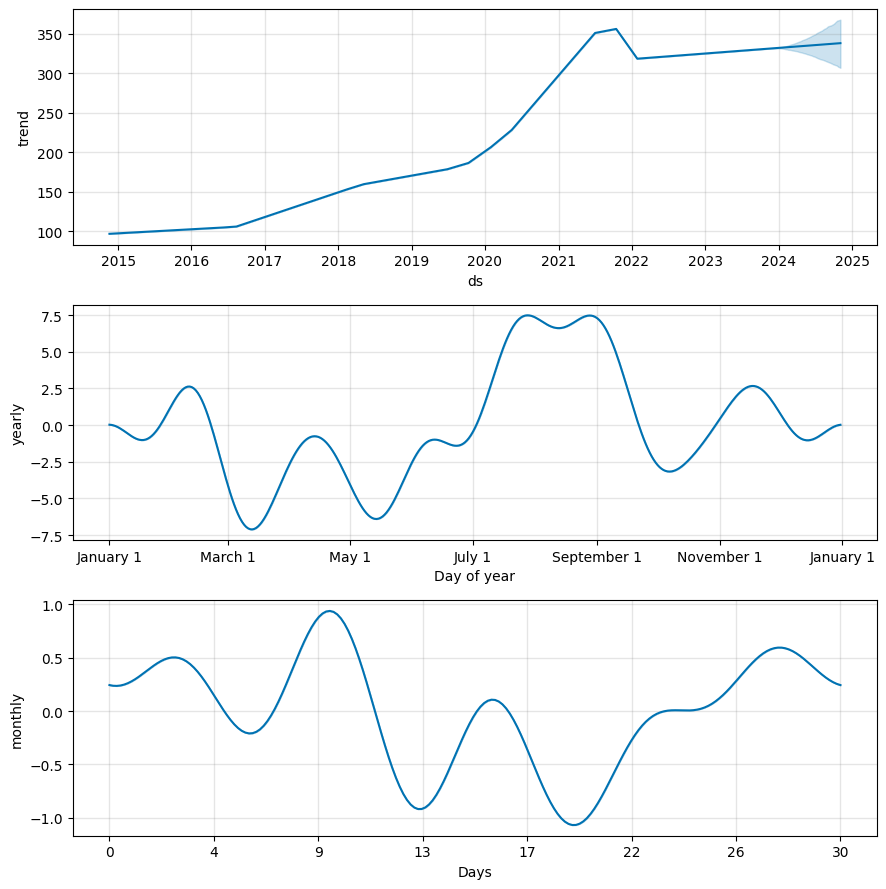

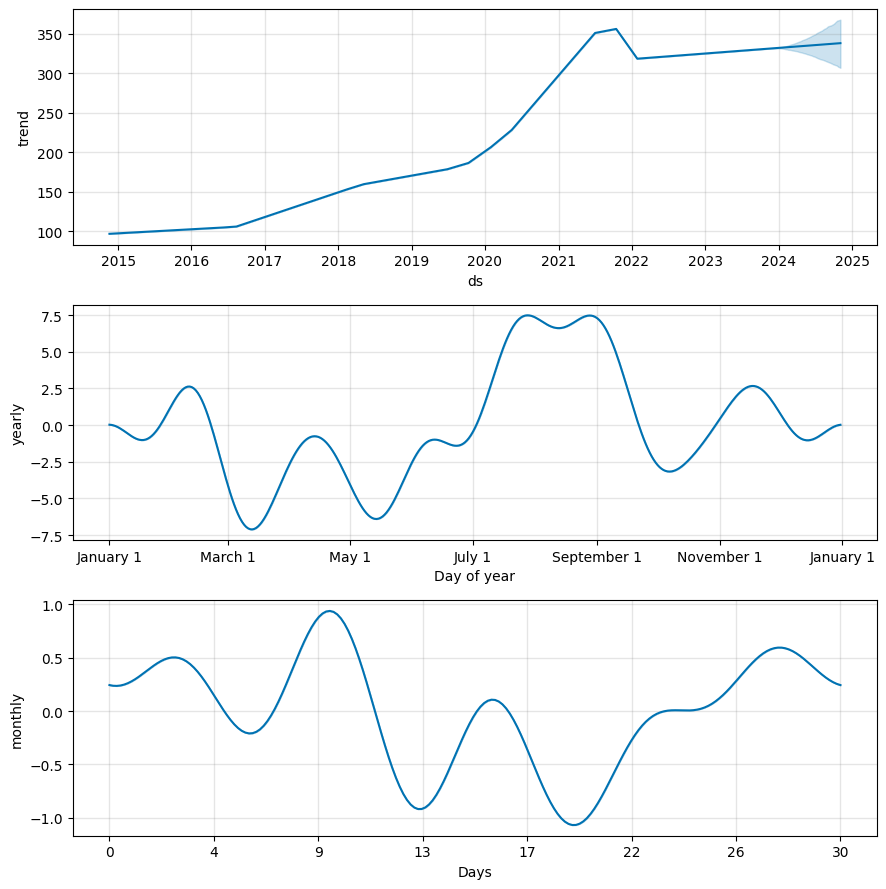

In [ ]:
m.plot_components(df2)